In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/full-filled-brain-stroke-dataset/full_data.csv
/kaggle/input/full-filled-brain-stroke-dataset/full_filled_stroke_data (1).csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

**Data Preparation**

In [3]:
sns.set(rc = {'figure.figsize':(30,20)})
sns.set_theme(style='white')

In [4]:
brain_train = pd.read_csv('../input/full-filled-brain-stroke-dataset/full_data.csv')
brain_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


Checking if any null values exist.

In [5]:
missdat = brain_train.isnull()
for column in missdat.columns.values.tolist():
    print(column)
    print (missdat[column].value_counts())
    print("")    

gender
False    4981
Name: gender, dtype: int64

age
False    4981
Name: age, dtype: int64

hypertension
False    4981
Name: hypertension, dtype: int64

heart_disease
False    4981
Name: heart_disease, dtype: int64

ever_married
False    4981
Name: ever_married, dtype: int64

work_type
False    4981
Name: work_type, dtype: int64

Residence_type
False    4981
Name: Residence_type, dtype: int64

avg_glucose_level
False    4981
Name: avg_glucose_level, dtype: int64

bmi
False    4981
Name: bmi, dtype: int64

smoking_status
False    4981
Name: smoking_status, dtype: int64

stroke
False    4981
Name: stroke, dtype: int64



No null values exists! Awesome!
Now checking for any inconsistencies in data types.

In [6]:
brain_train.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

All data types seems fine. Maybe age needs to be converted to int rather than float.

In [7]:
brain_train[['age']] = brain_train[['age']].astype('int')
brain_train.dtypes

gender                object
age                    int64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Now everything seems to be in order considering data types.

In [8]:
brain_train.shape

(4981, 11)

In [9]:
brain_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


Let's take a look at the correlation between all the columns.

<AxesSubplot:>

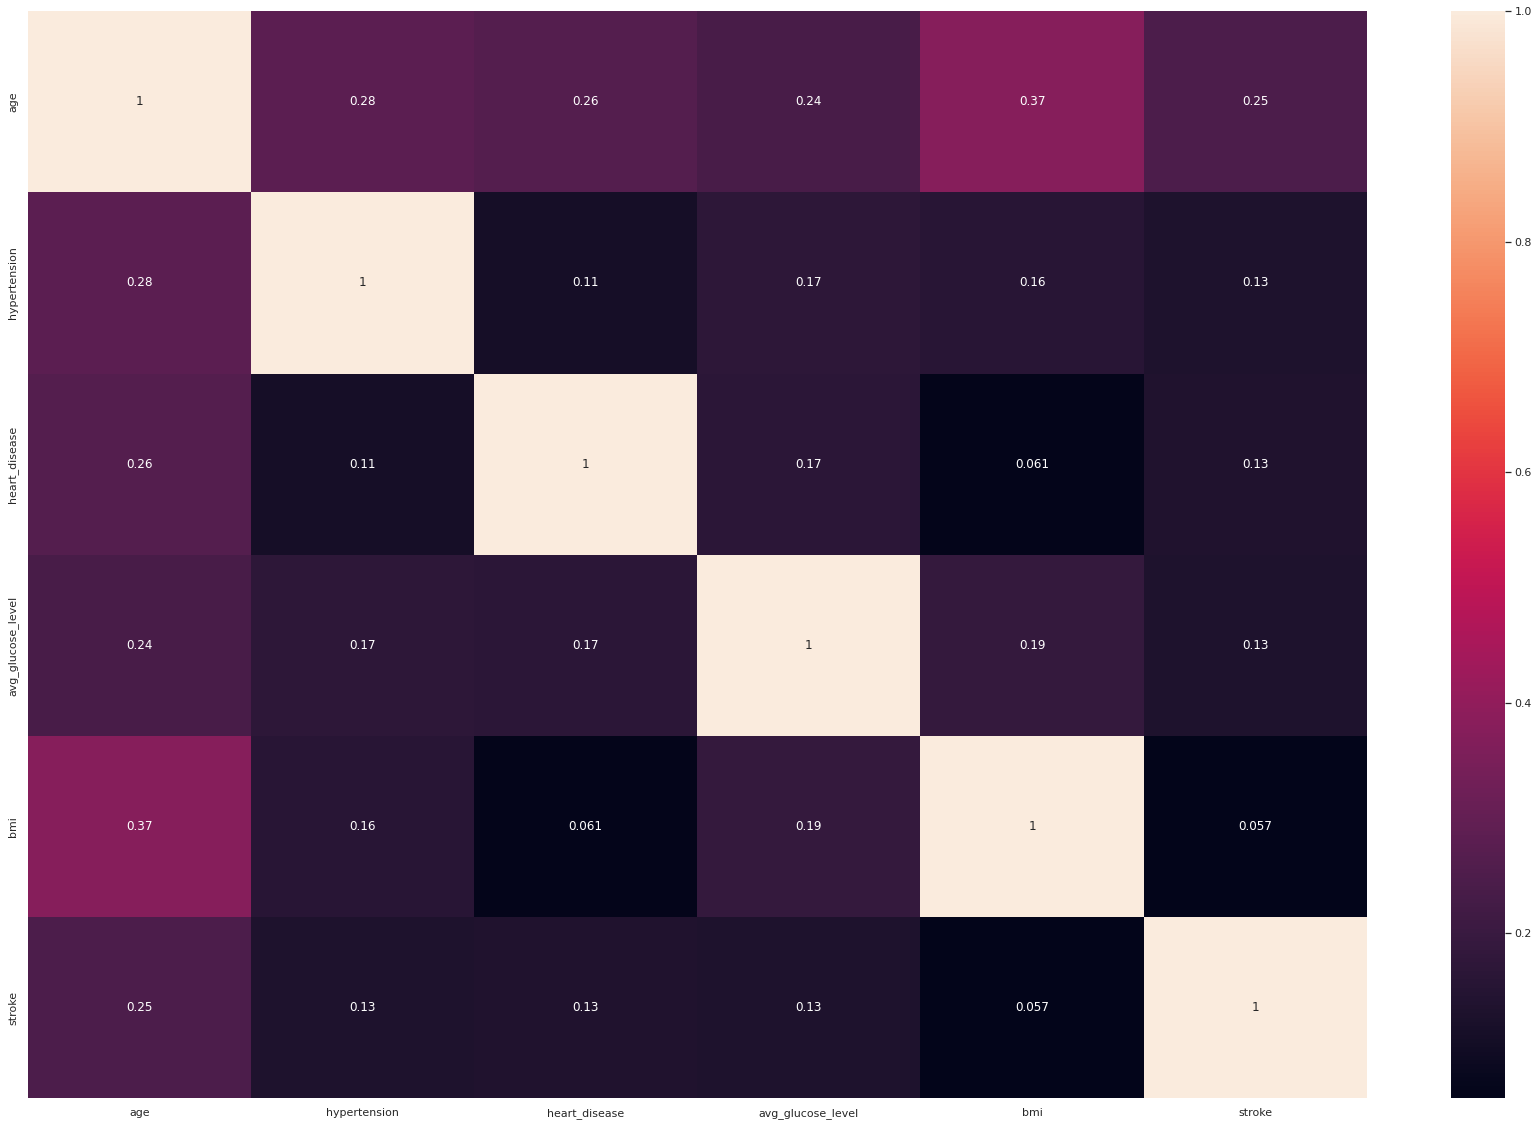

In [10]:
sns.heatmap(brain_train.corr(), annot=True)

Creating 5 bins for age.

In [11]:
bins = np.linspace(min(brain_train['age']), max(brain_train['age']), 6)
group_names = ['Young', 'Young Adult', 'Prime', 'Early old', 'Old']

brain_train['age-binned'] = pd.cut(brain_train['age'], bins, labels=group_names, include_lowest=True )
brain_train[['age','age-binned']].head(20)

,age,age-binned
0,67,Old
1,80,Old
2,49,Prime
3,79,Old
4,81,Old
5,74,Old
6,69,Old
7,78,Old
8,81,Old
9,61,Early old


Let's see the number of people in each age group.

In [12]:
brain_train['age-binned'].value_counts()

Early old      1214
Prime          1143
Old             959
Young Adult     895
Young           770
Name: age-binned, dtype: int64

In [13]:
brain_train_2 = brain_train.copy()
brain_train_2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age-binned
0,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Old
1,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Old
2,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Prime
3,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Old
4,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,Old


**EDA**

Text(0.5, 1.0, 'age bins')

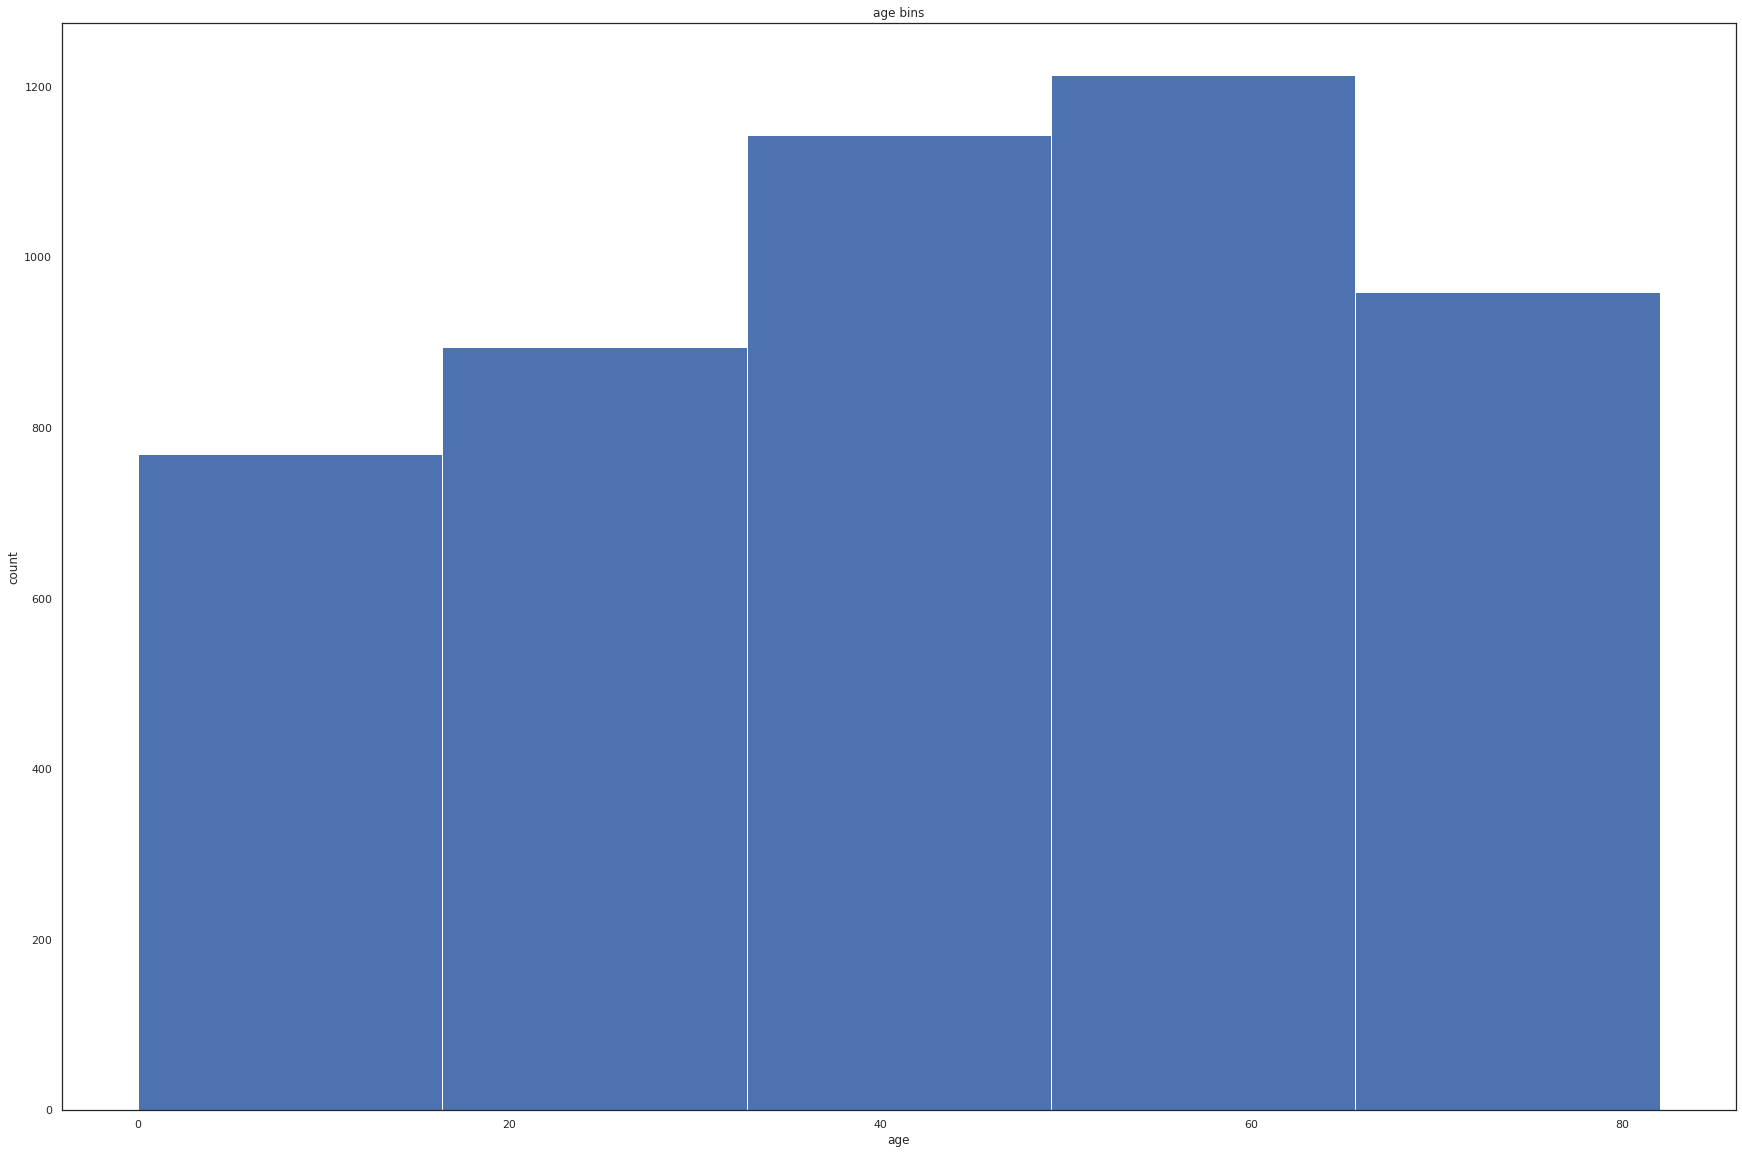

In [14]:
plt.hist(brain_train['age'], bins = 5)

# set x/y labels and plot title
plt.xlabel('age')
plt.ylabel('count')
plt.title('age bins')

age-binned
Young            2
Young Adult      1
Prime           16
Early old       73
Old            156
Name: stroke, dtype: int64


<AxesSubplot:xlabel='age-binned'>

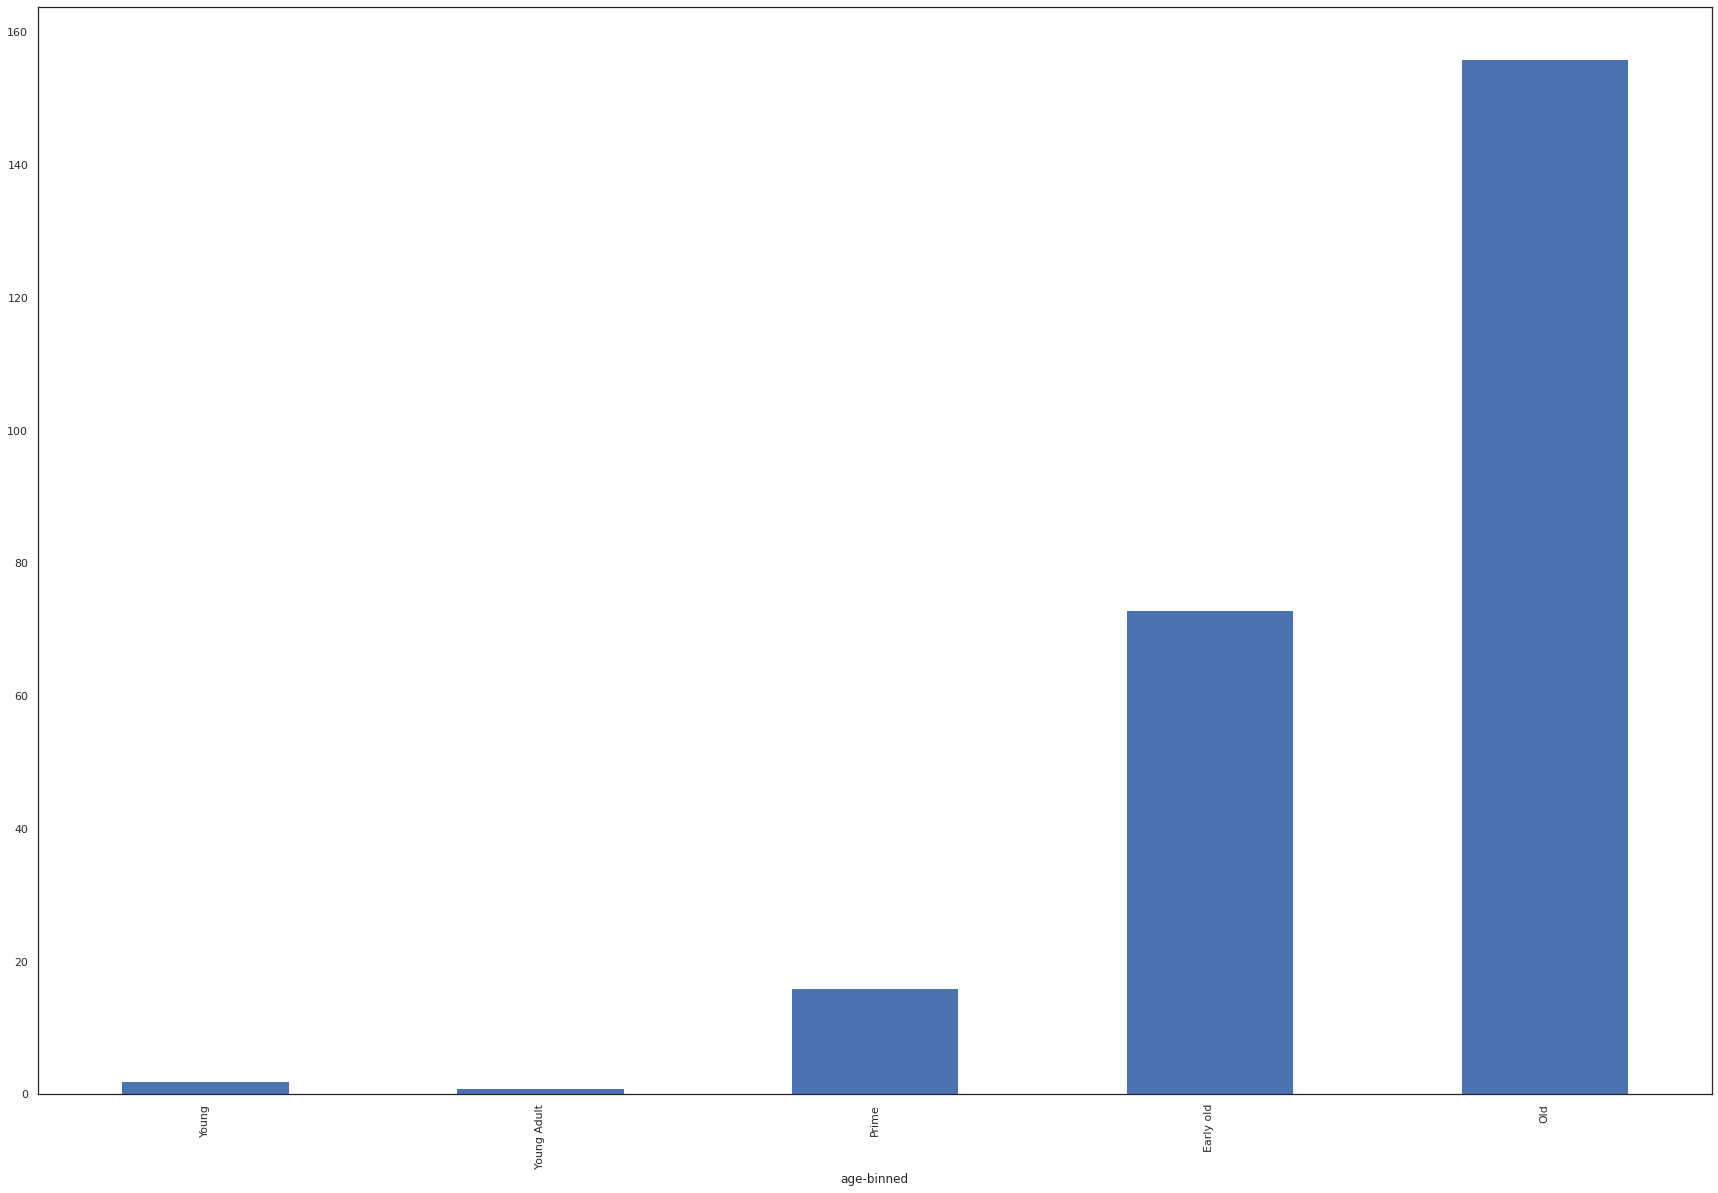

In [15]:
print(brain_train_2.groupby('age-binned')['stroke'].sum())
brain_train_2.groupby('age-binned')['stroke'].sum().plot(kind='bar', figsize=(30,20))

An interesting trend. People who are in old category have higher stroke counts. However, it could also be the case that because 'old' bin has higher instances, it could reflect in higher number of strokes. 
There is also a rising trend of more instances of stroke. Now even considering the difference between data instances between age groups, it is clear that there is a rise in trend i.e. as people get older there is a higher chance of getting a stroke.

never smoked       1838
Unknown            1500
formerly smoked     867
smokes              776
Name: smoking_status, dtype: int64
smoking_status
Unknown            47
formerly smoked    70
never smoked       89
smokes             42
Name: stroke, dtype: int64


<AxesSubplot:title={'center':'Stroke Instance based on Smoking Status'}, xlabel='smoking_status'>

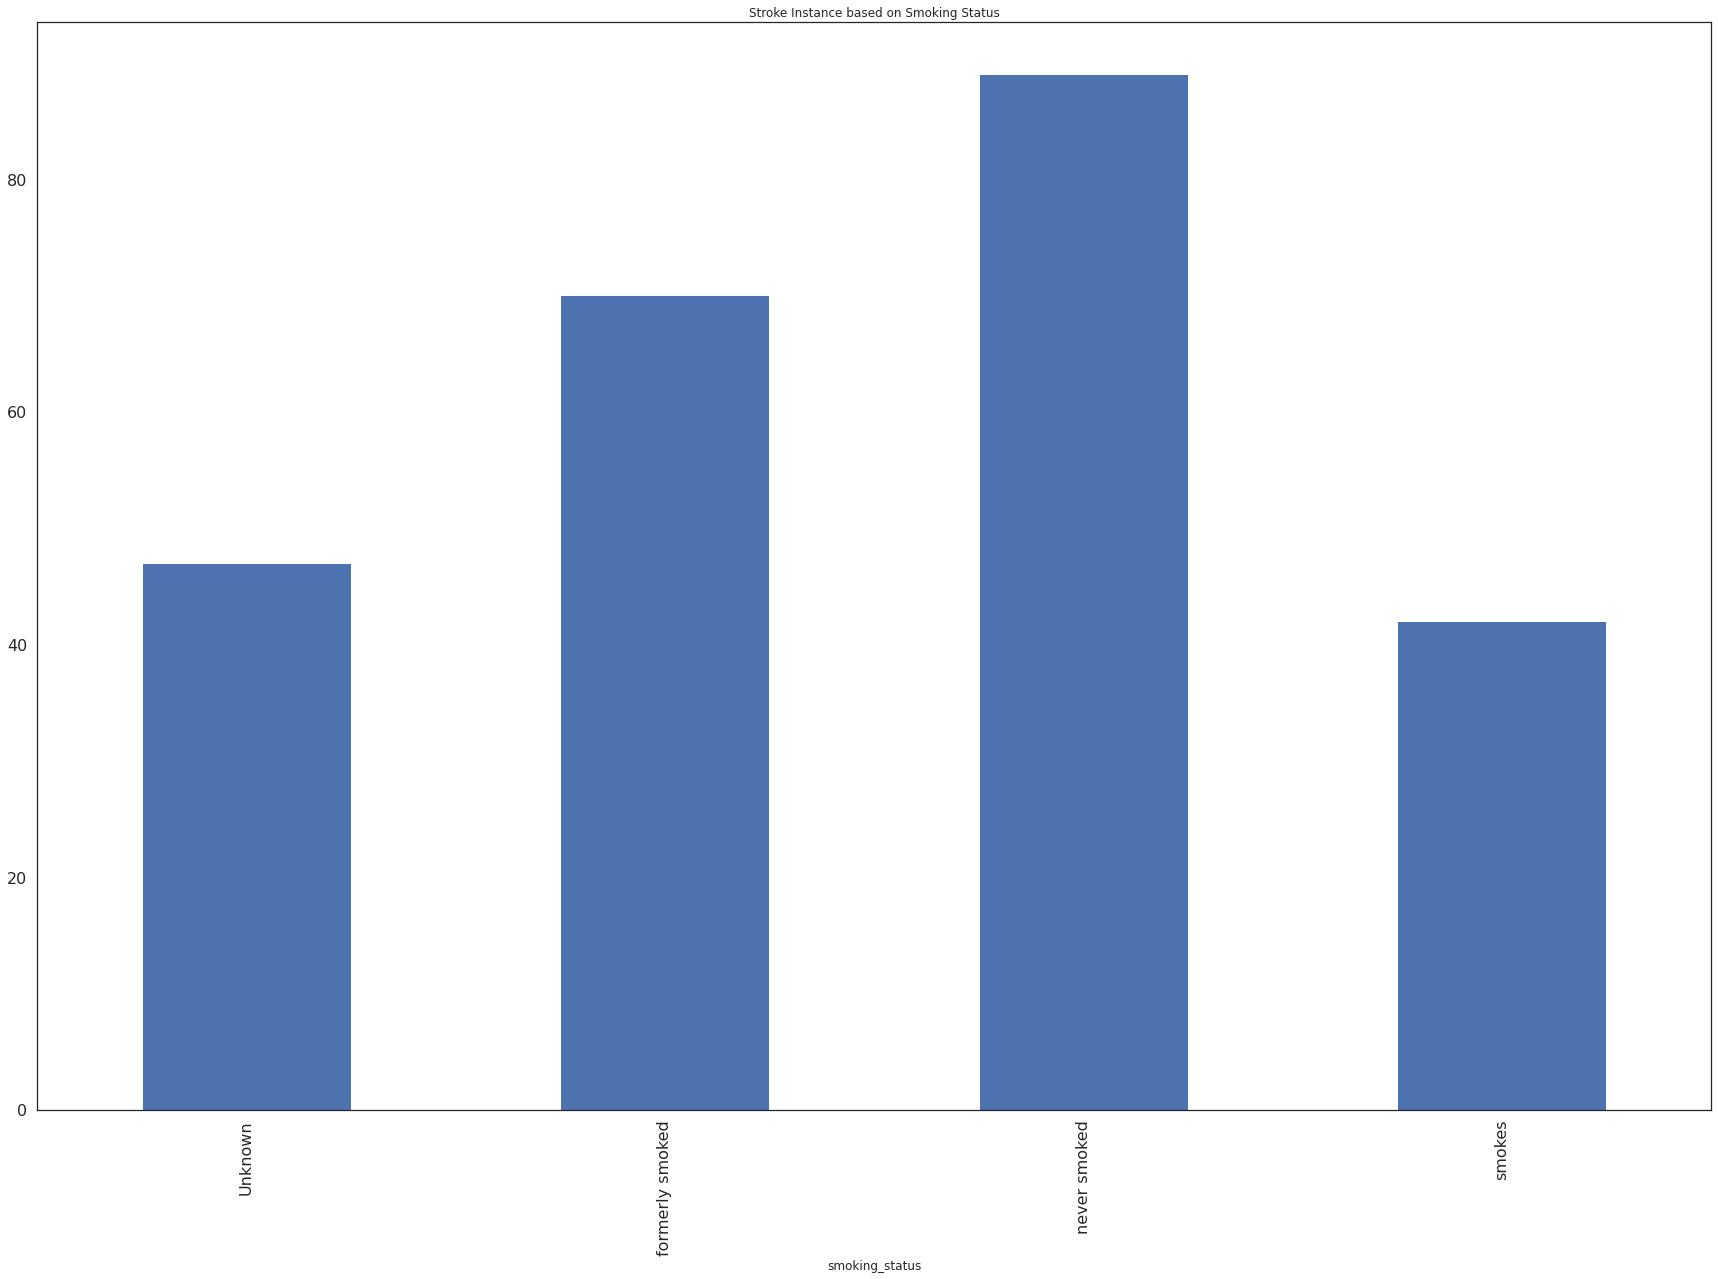

In [16]:
print(brain_train_2['smoking_status'].value_counts())
print(brain_train_2.groupby('smoking_status')['stroke'].sum())
brain_train_2.groupby('smoking_status')['stroke'].sum().plot(kind='bar', figsize=(30,20), title="Stroke Instance based on Smoking Status", fontsize=16)

People who have never smoked or used to smoke seems to have a higher count of strokes recorded compared to those who regularly smokes. 

Maybe the reason is stress relief?

In [17]:
brain_train_2['Residence_type'].value_counts()

Urban    2532
Rural    2449
Name: Residence_type, dtype: int64

Residence_type
Rural    113
Urban    135
Name: stroke, dtype: int64


<AxesSubplot:title={'center':'Stroke Instance based on Smoking Status'}, xlabel='Residence Type'>

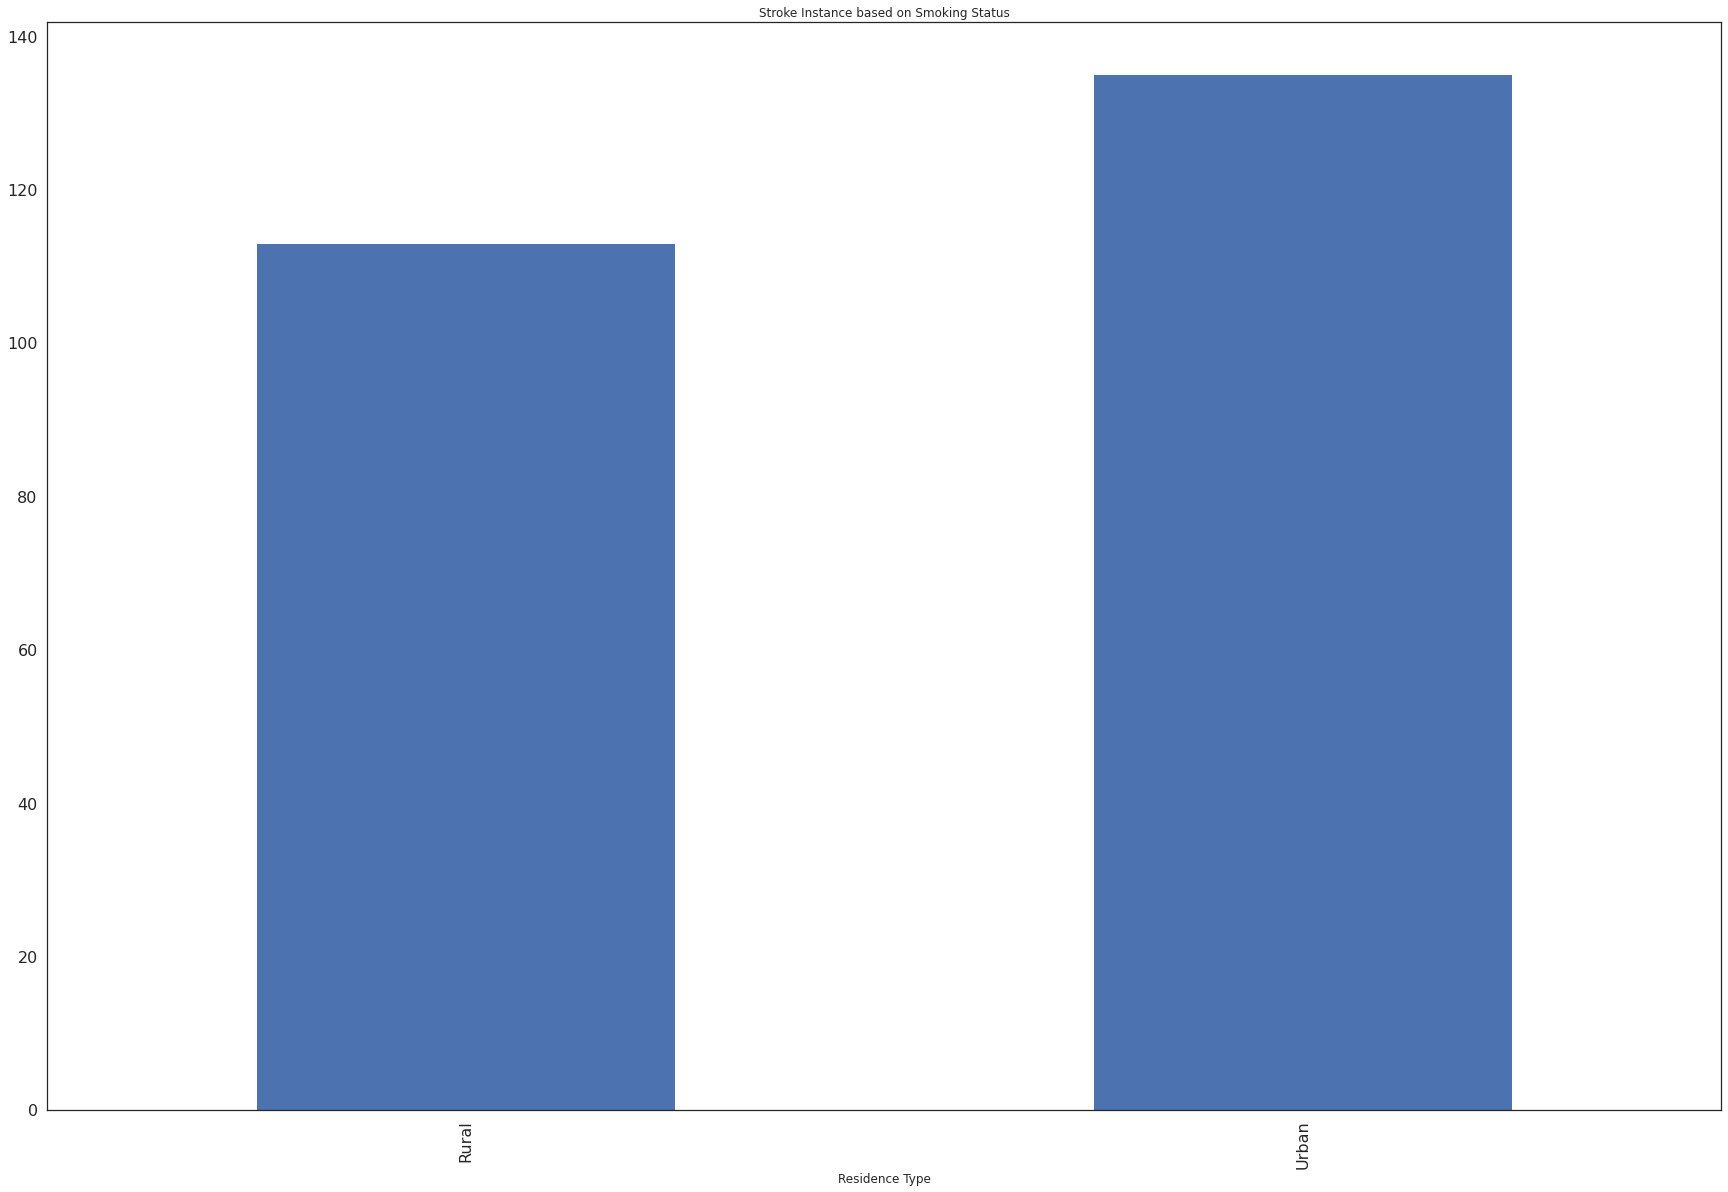

In [18]:
print(brain_train_2.groupby('Residence_type')['stroke'].sum())
brain_train_2.groupby('Residence_type')['stroke'].sum().plot(kind='bar', figsize=(30,20), title="Stroke Instance based on Smoking Status", fontsize=16, xlabel='Residence Type')

People who live in urban setting seem to have more instances of stroke. However, this lead is not by a lot. Also considering that there is a similar trend where there are more instances of urban residence type than rural, it might explain the slight lead shown in the graph above.

In [19]:
brain_train_2['work_type'].value_counts()

Private          2860
Self-employed     804
children          673
Govt_job          644
Name: work_type, dtype: int64

work_type
Govt_job          33
Private          148
Self-employed     65
children           2
Name: stroke, dtype: int64


<AxesSubplot:title={'center':'Stroke Instance based on Work Type'}, xlabel='Work Type'>

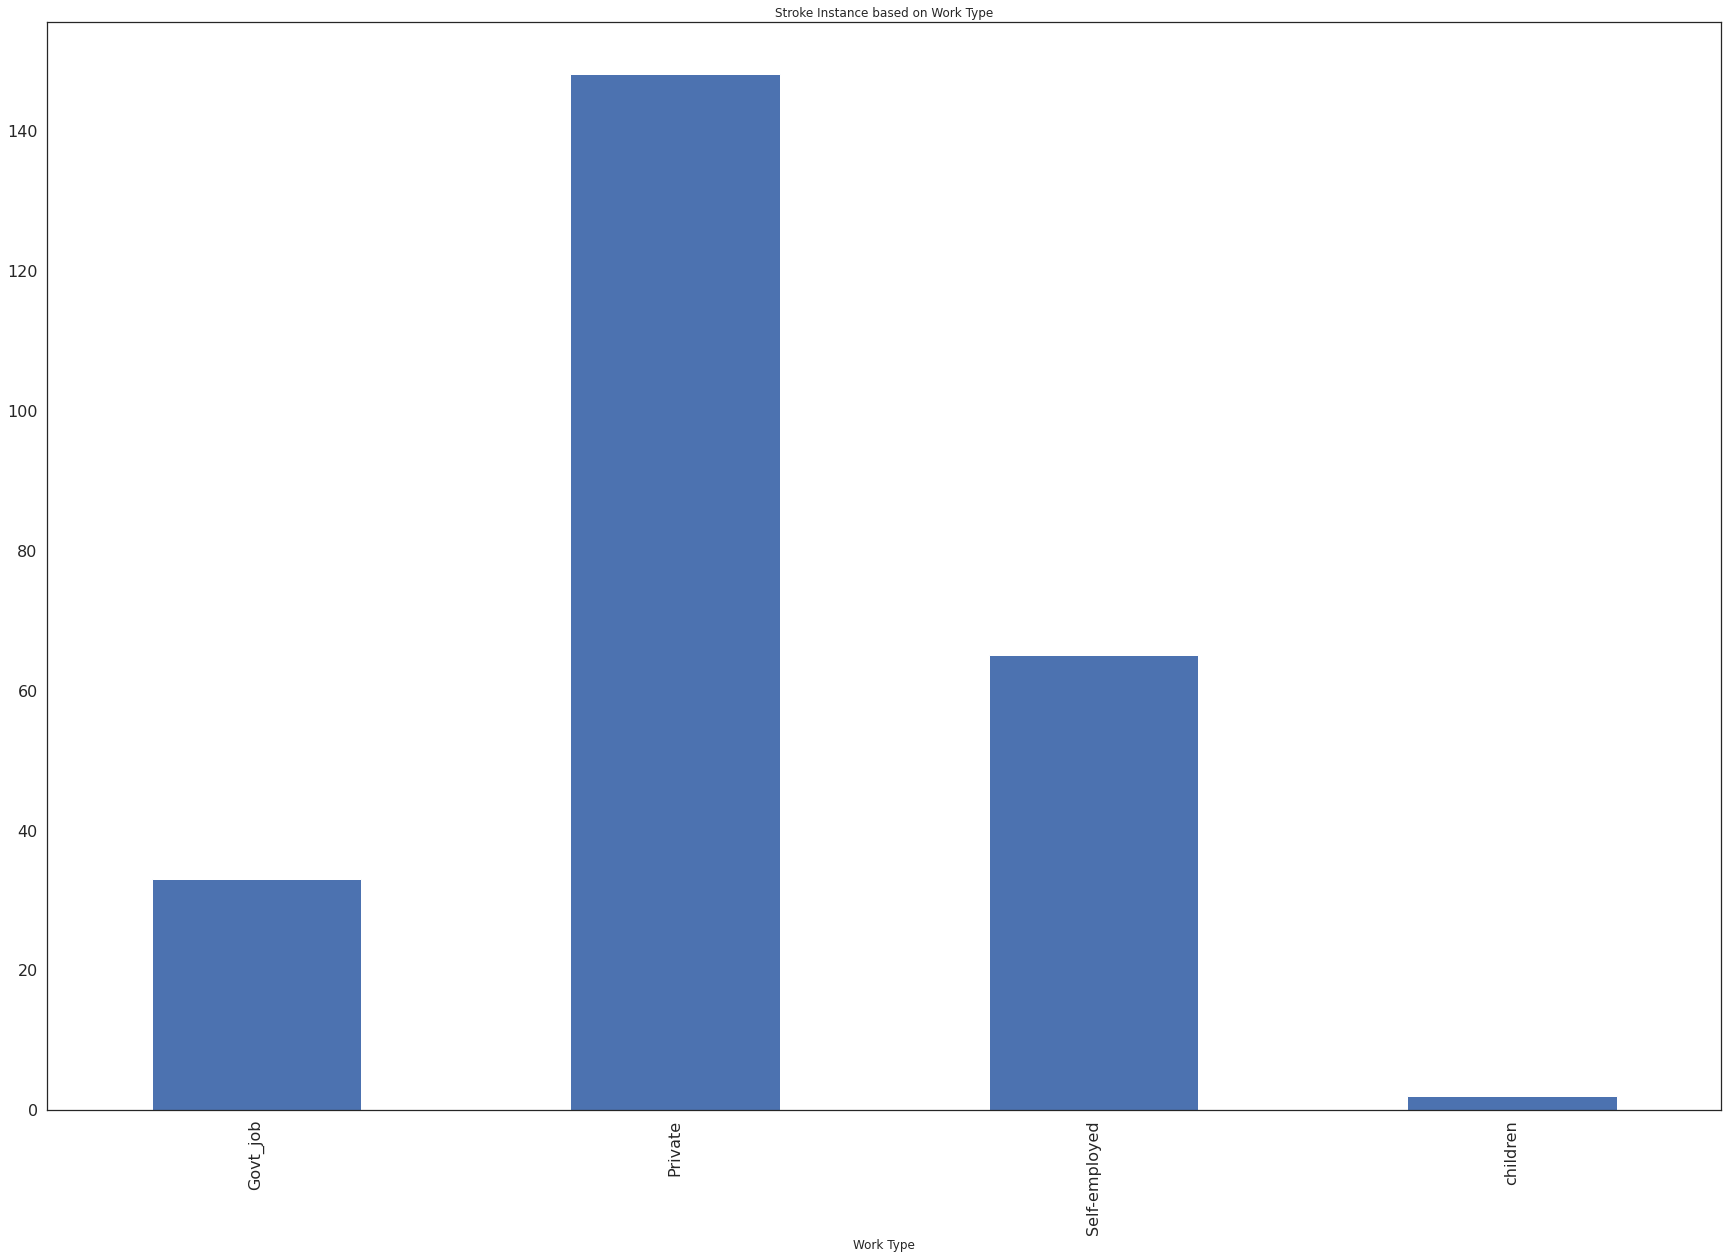

In [20]:
print(brain_train_2.groupby('work_type')['stroke'].sum())
brain_train_2.groupby('work_type')['stroke'].sum().plot(kind='bar', figsize=(30,20), title="Stroke Instance based on Work Type", fontsize=16, xlabel='Work Type')

Based on work type, there is a high discrepency between the frequency of each type of data. So taking the percent is the obvious method to move forward. 

<AxesSubplot:title={'center':'Stroke Instance Percent based on Work Type'}, xlabel='Work Type'>

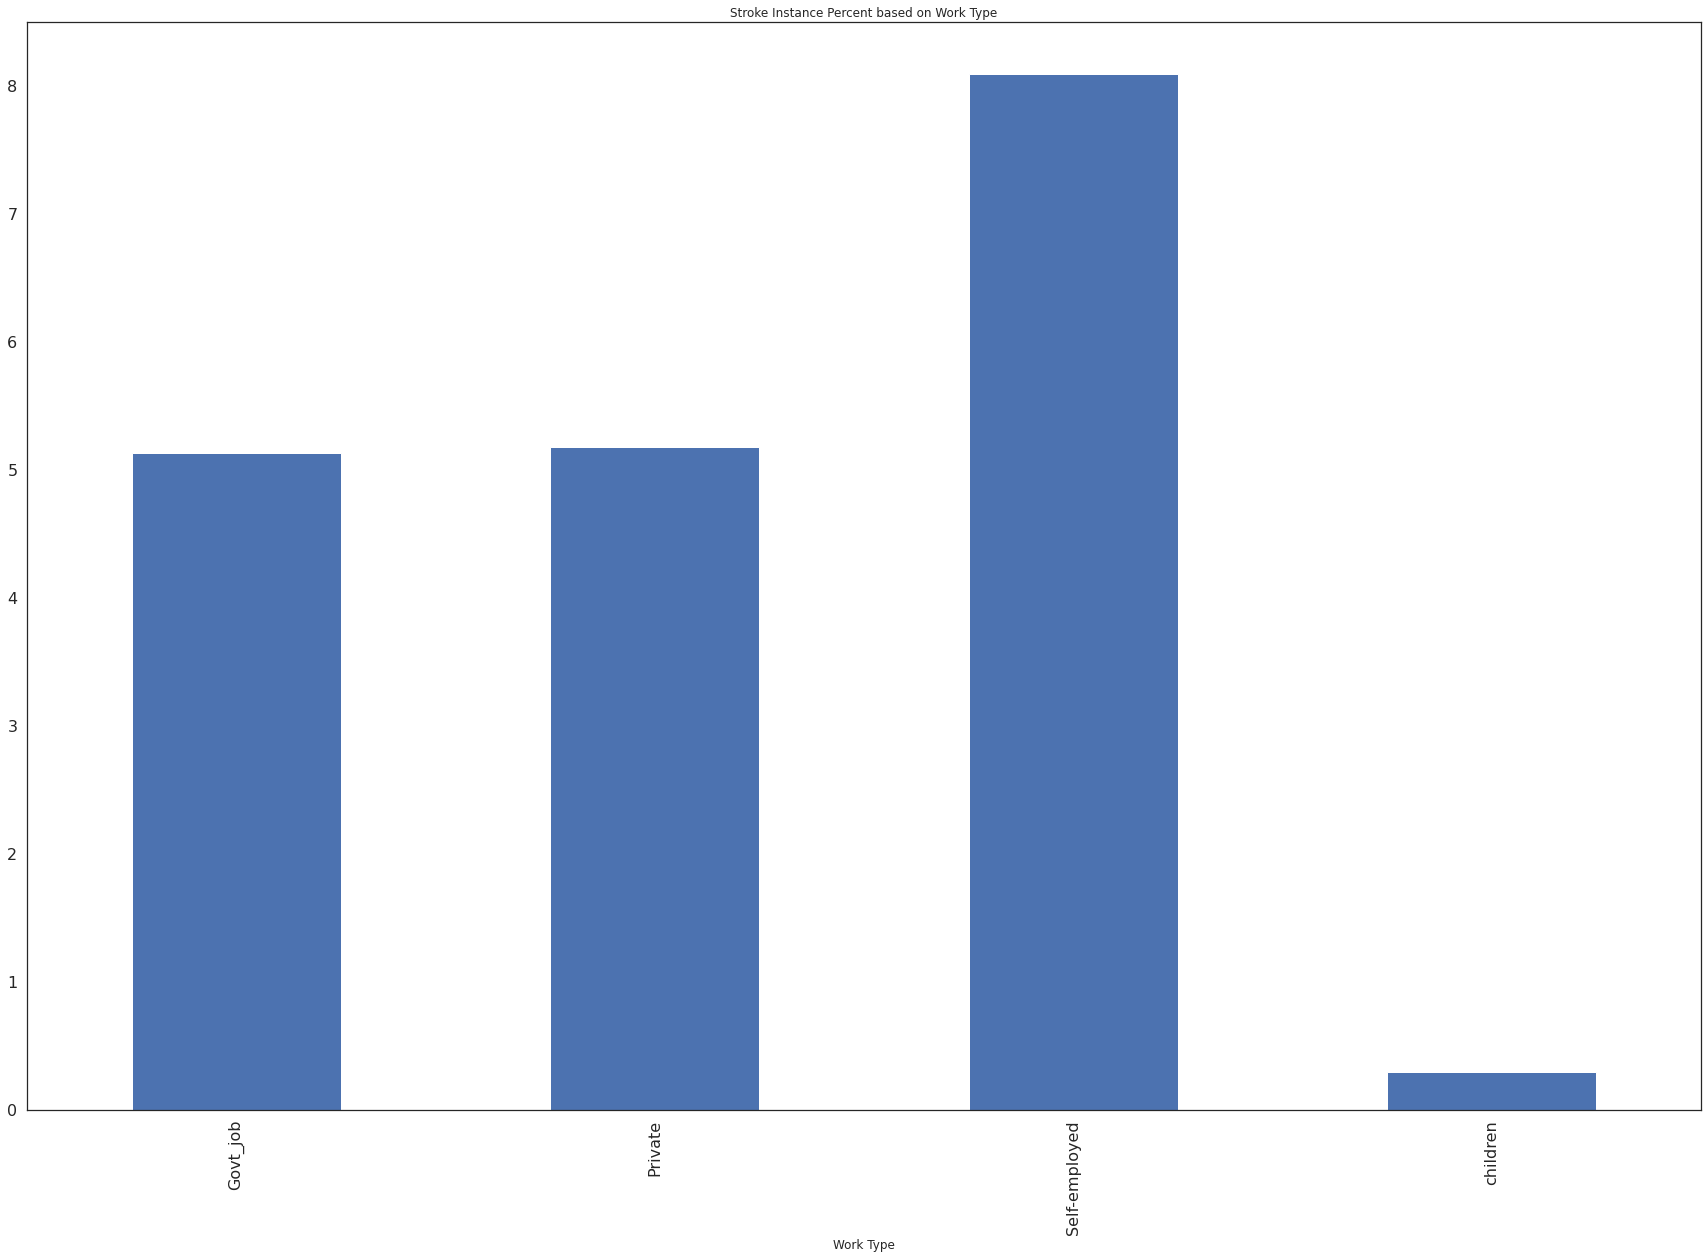

In [21]:
brain_train_3 = (brain_train_2.groupby('work_type')['stroke'].sum())/brain_train_2['work_type'].value_counts()
brain_train_3 = brain_train_3 * 100
brain_train_3.plot(kind='bar', figsize=(30,20), title="Stroke Instance Percent based on Work Type", fontsize=16, xlabel='Work Type')

Here we can see that people who are self-employed tend to have a higher chances of getting a stroke. While private and government job employees have almost similar chances with the lowest belonging to children. 

A picture is forming, every factor that is stress inducing have a higher chance of triggering a stroke. Like smoking that allegedly reduces stress, people who smoke have lesser chance to get a stroke. Similarly, self-employed individuals are more likely to have more stress than compared to people having government or private jobs. 
Another factor that is emerging is age. Where, higher the age, higher the chances of getting stroke. 

age-binned   ever_married
Young        No               770
Young Adult  No               598
             Yes              297
Prime        Yes              981
             No               162
Early old    Yes             1126
             No                88
Old          Yes              876
             No                83
Name: ever_married, dtype: int64


<AxesSubplot:title={'center':'Stroke Instance based on Ever Married'}, xlabel='Work Type'>

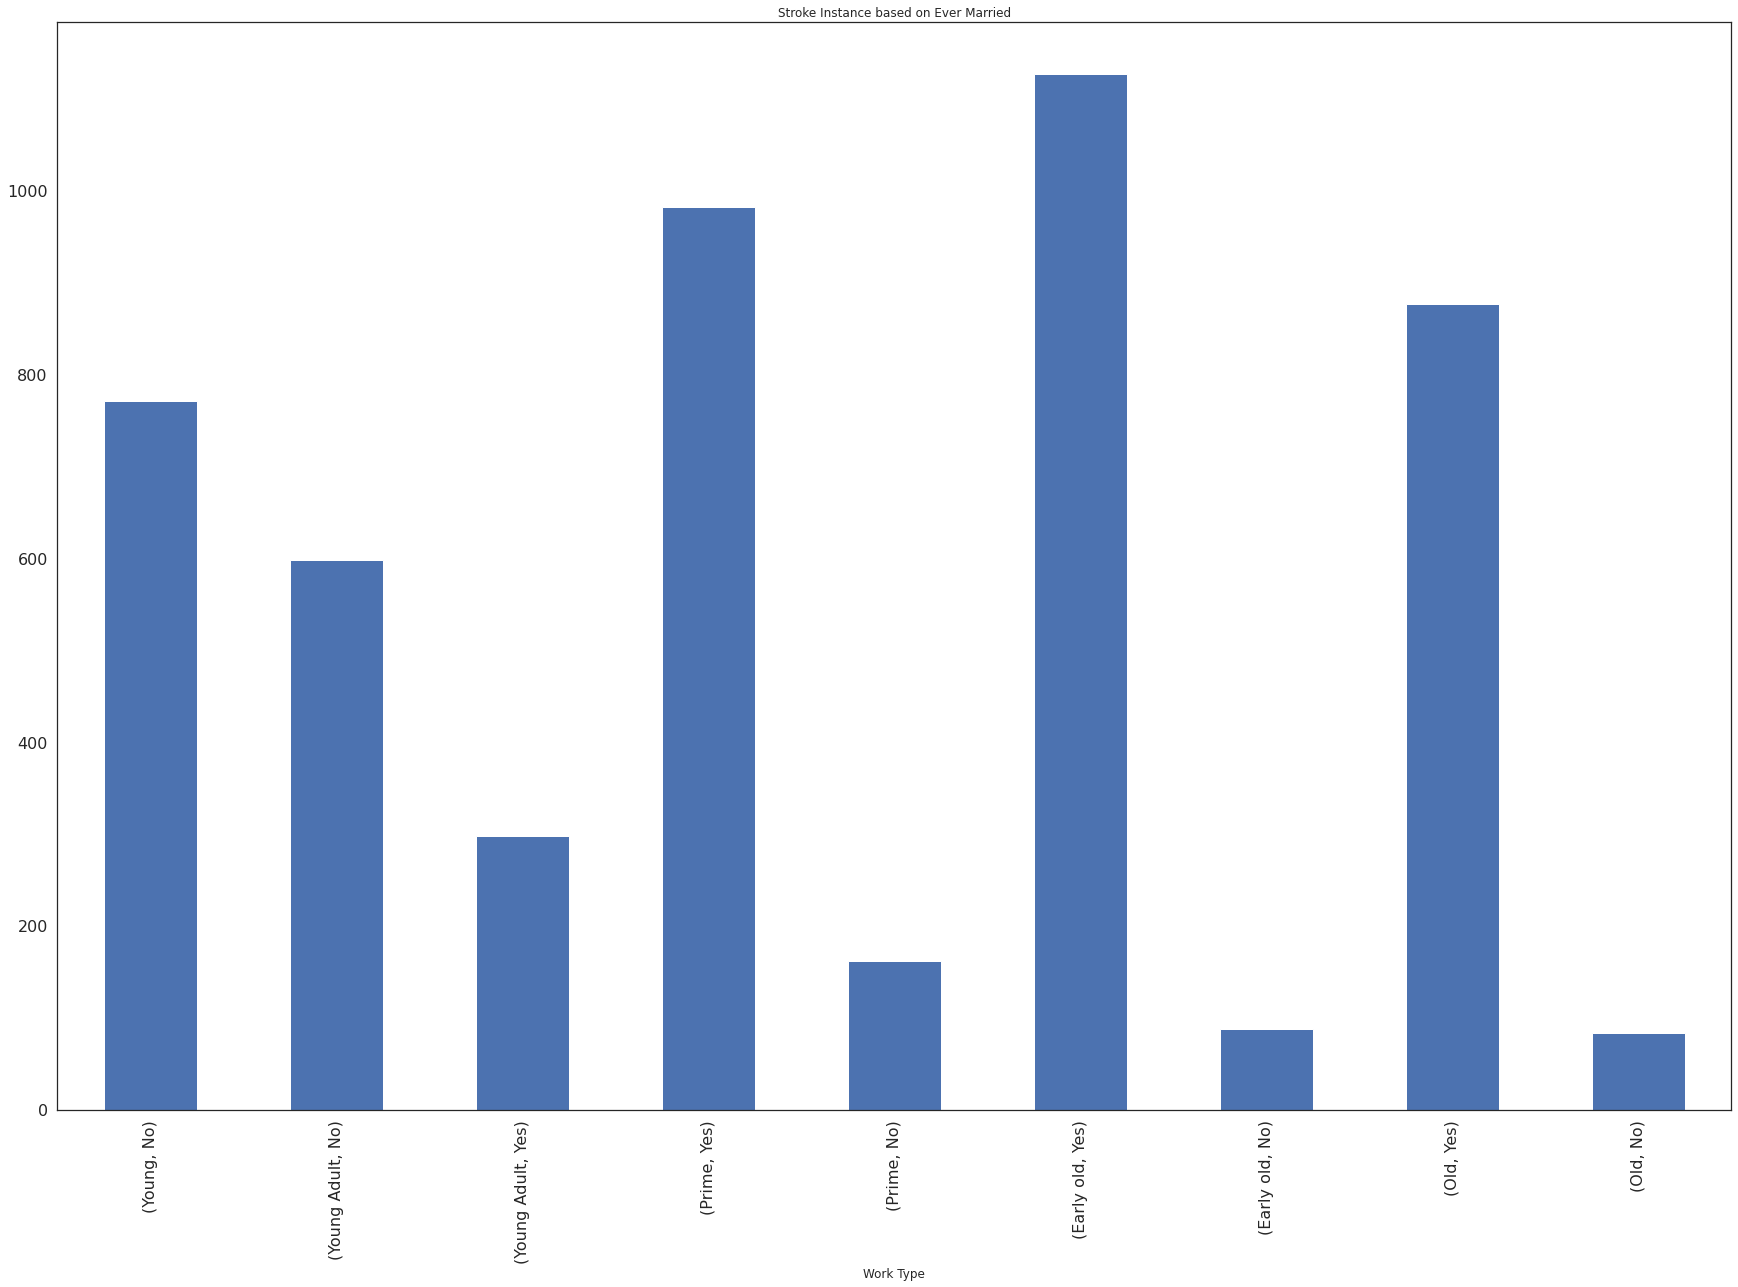

In [22]:
print(brain_train_2.groupby('age-binned')['ever_married'].value_counts())
brain_train_2.groupby('age-binned')['ever_married'].value_counts().plot(kind='bar', figsize=(30,20), title="Stroke Instance based on Ever Married", fontsize=16, xlabel='Work Type')

ever_married
No      29
Yes    219
Name: stroke, dtype: int64


<AxesSubplot:title={'center':'Stroke Instance based on Ever Married'}, xlabel='Ever Married'>

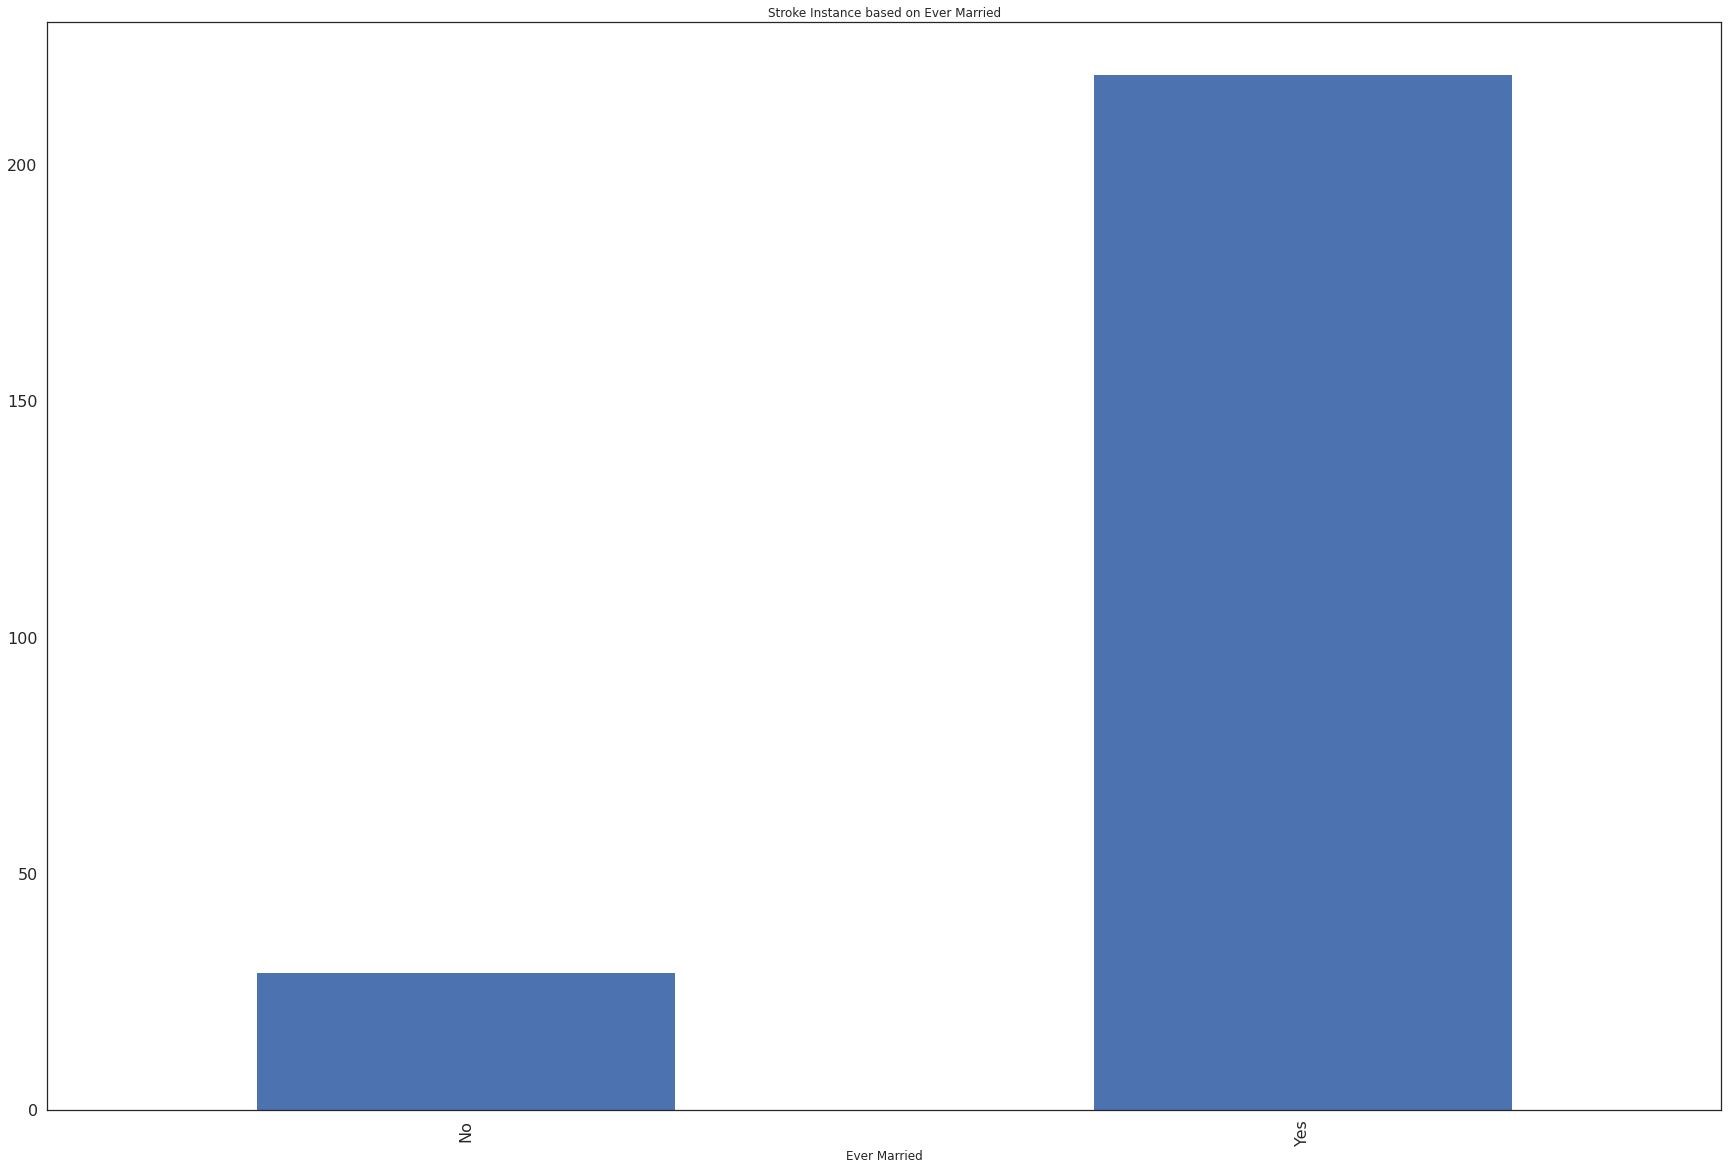

In [23]:
print(brain_train_2.groupby('ever_married')['stroke'].sum())
brain_train_2.groupby('ever_married')['stroke'].sum().plot(kind='bar', figsize=(30,20), title="Stroke Instance based on Ever Married", fontsize=16, xlabel='Ever Married')

ever married is a factor in determining if a stroke could occur or not. But it is kind of intiutive. From the graph above this, it is clear that there is a rise in positives as we move across age bins. And as we determined earlier, stroke chances are higher in higher age groups. 

The frequency of positive for ever married in young and young adult is low (obviously!) and since those age groups have quite low stroke instances as well, it explains the extremely low value for the negative value in ever married.

In [24]:
brain_train_2['hypertension'].value_counts()

0    4502
1     479
Name: hypertension, dtype: int64

hypertension
0    182
1     66
Name: stroke, dtype: int64


<AxesSubplot:title={'center':'Stroke Instance based on if a patient has Hypertension'}, xlabel='Hypertension'>

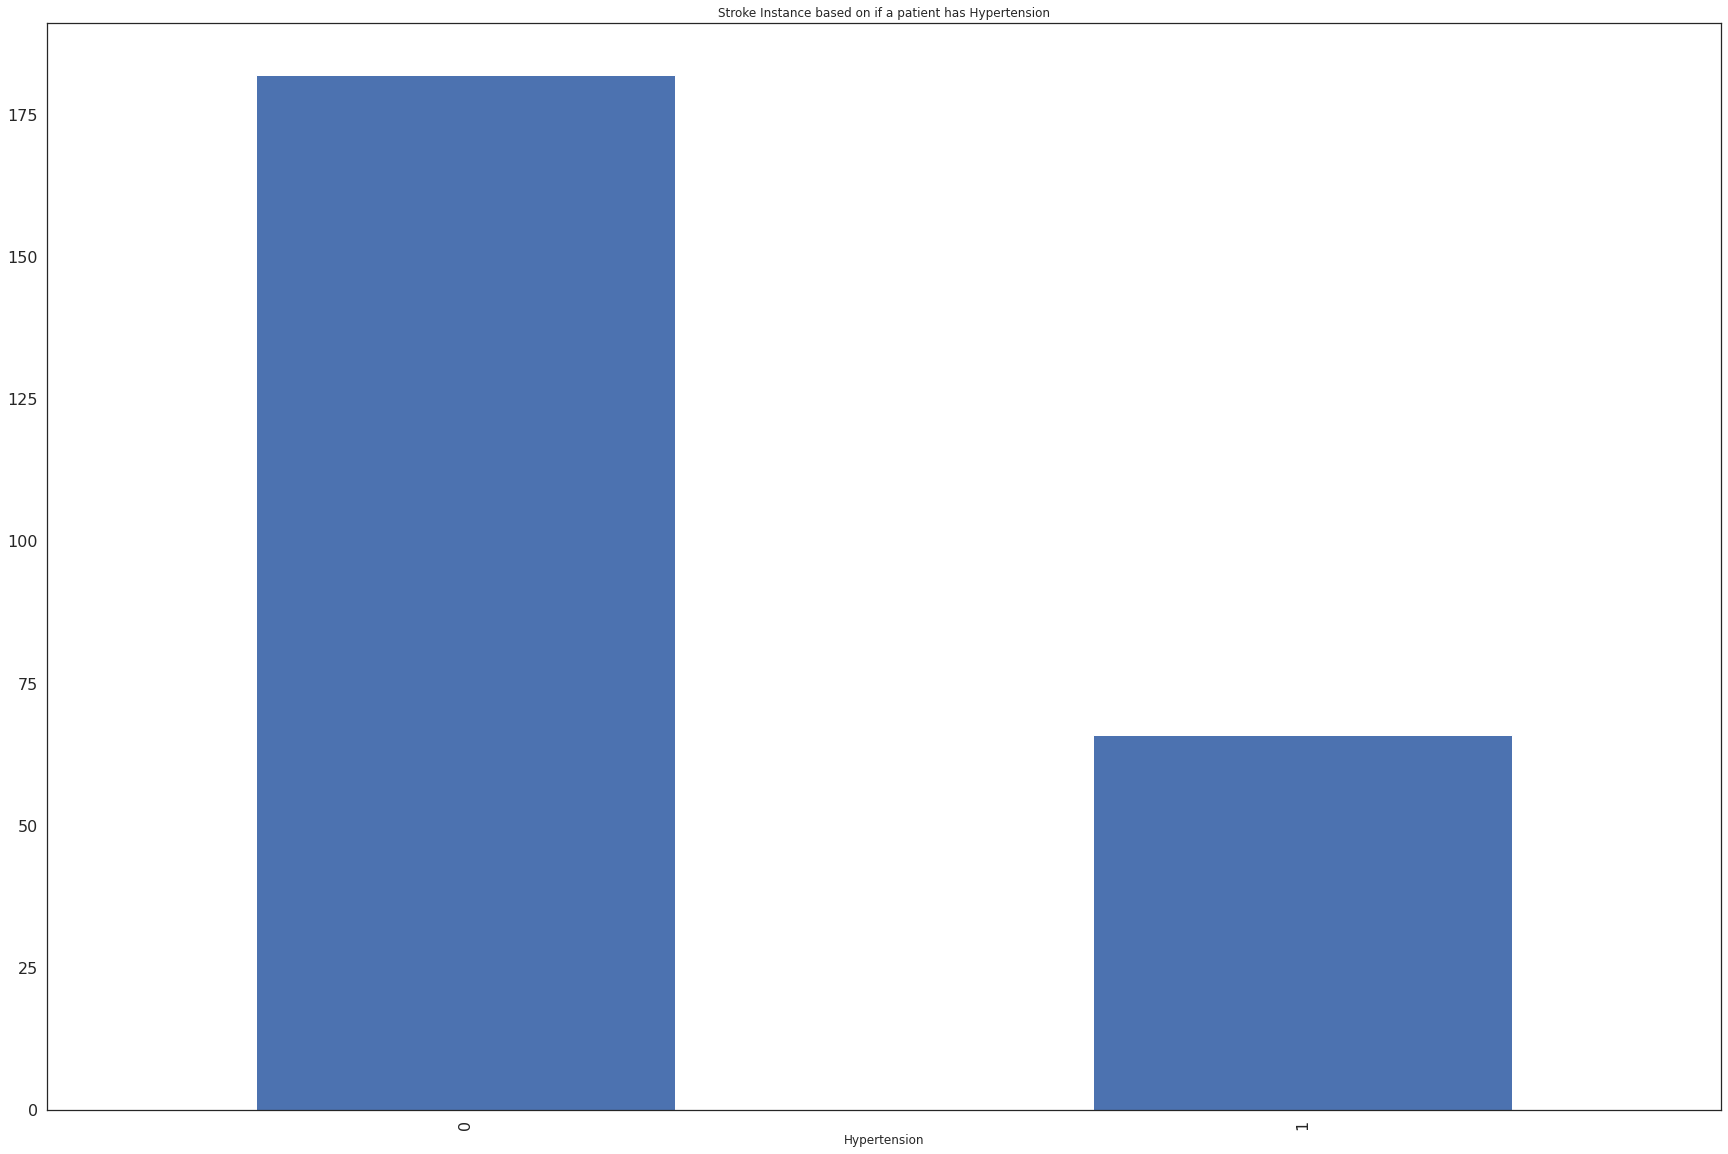

In [25]:
print(brain_train_2.groupby('hypertension')['stroke'].sum())
brain_train_2.groupby('hypertension')['stroke'].sum().plot(kind='bar', figsize=(30,20), title="Stroke Instance based on if a patient has Hypertension", fontsize=16, xlabel='Hypertension')

There is a huge disparity between the frequency of hypertension. So judging by taking percent seems a better option.

hypertension
0     4.042648
1    13.778706
dtype: float64


<AxesSubplot:title={'center':'Stroke Instance Percent based on if a patient has Hypertension'}, xlabel='Hypertension'>

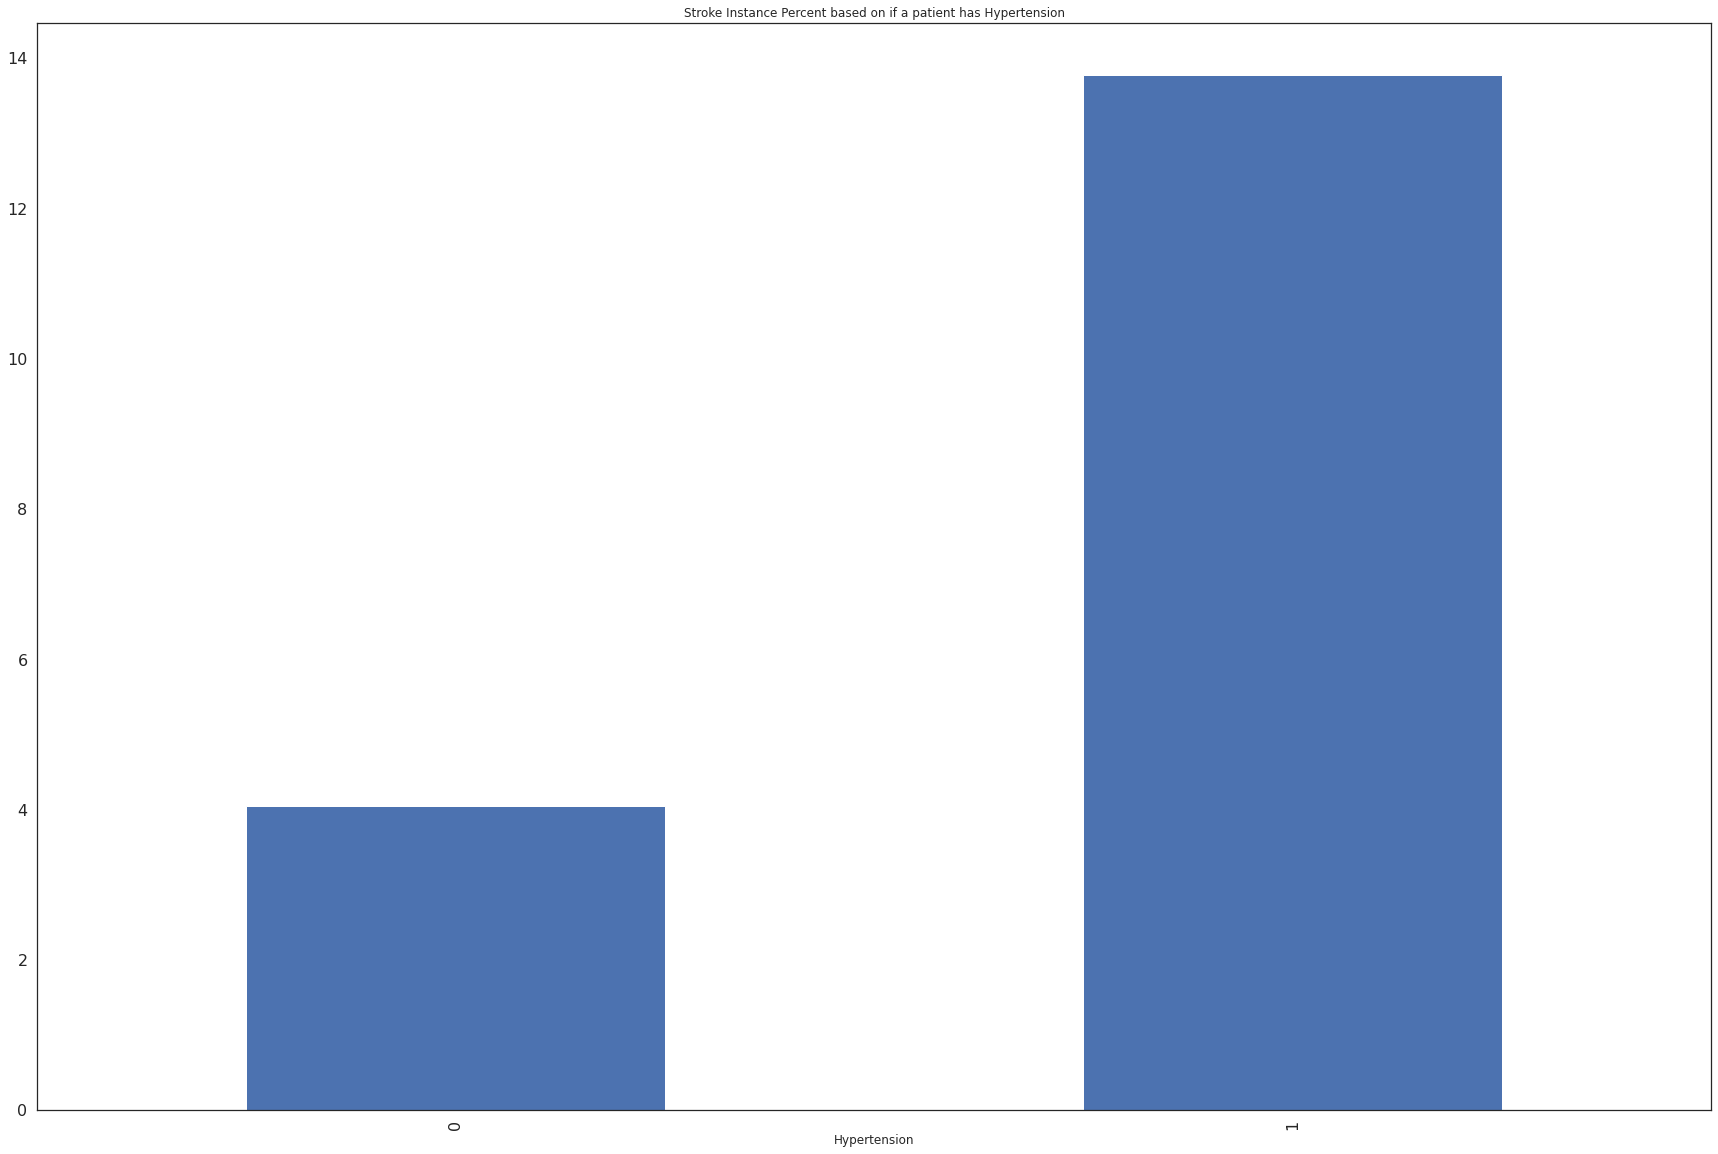

In [26]:
brain_train_3 = (brain_train_2.groupby('hypertension')['stroke'].sum())/brain_train_2['hypertension'].value_counts()
brain_train_3 = brain_train_3 * 100
print(brain_train_3)
brain_train_3.plot(kind='bar', figsize=(30,20), title="Stroke Instance Percent based on if a patient has Hypertension", fontsize=16, xlabel='Hypertension')

Aha! Now this makes more sense. People who have hypertension are more likely to have a stroke. 13.7% of people who have hypertension, based on the database, have suffered stroke

In [27]:
brain_train_2['stroke'].value_counts()

0    4733
1     248
Name: stroke, dtype: int64

heart_disease
0    201
1     47
Name: stroke, dtype: int64


<AxesSubplot:title={'center':'Stroke Instance based on if a patient has a Heart Disease'}, xlabel='Heart Disease'>

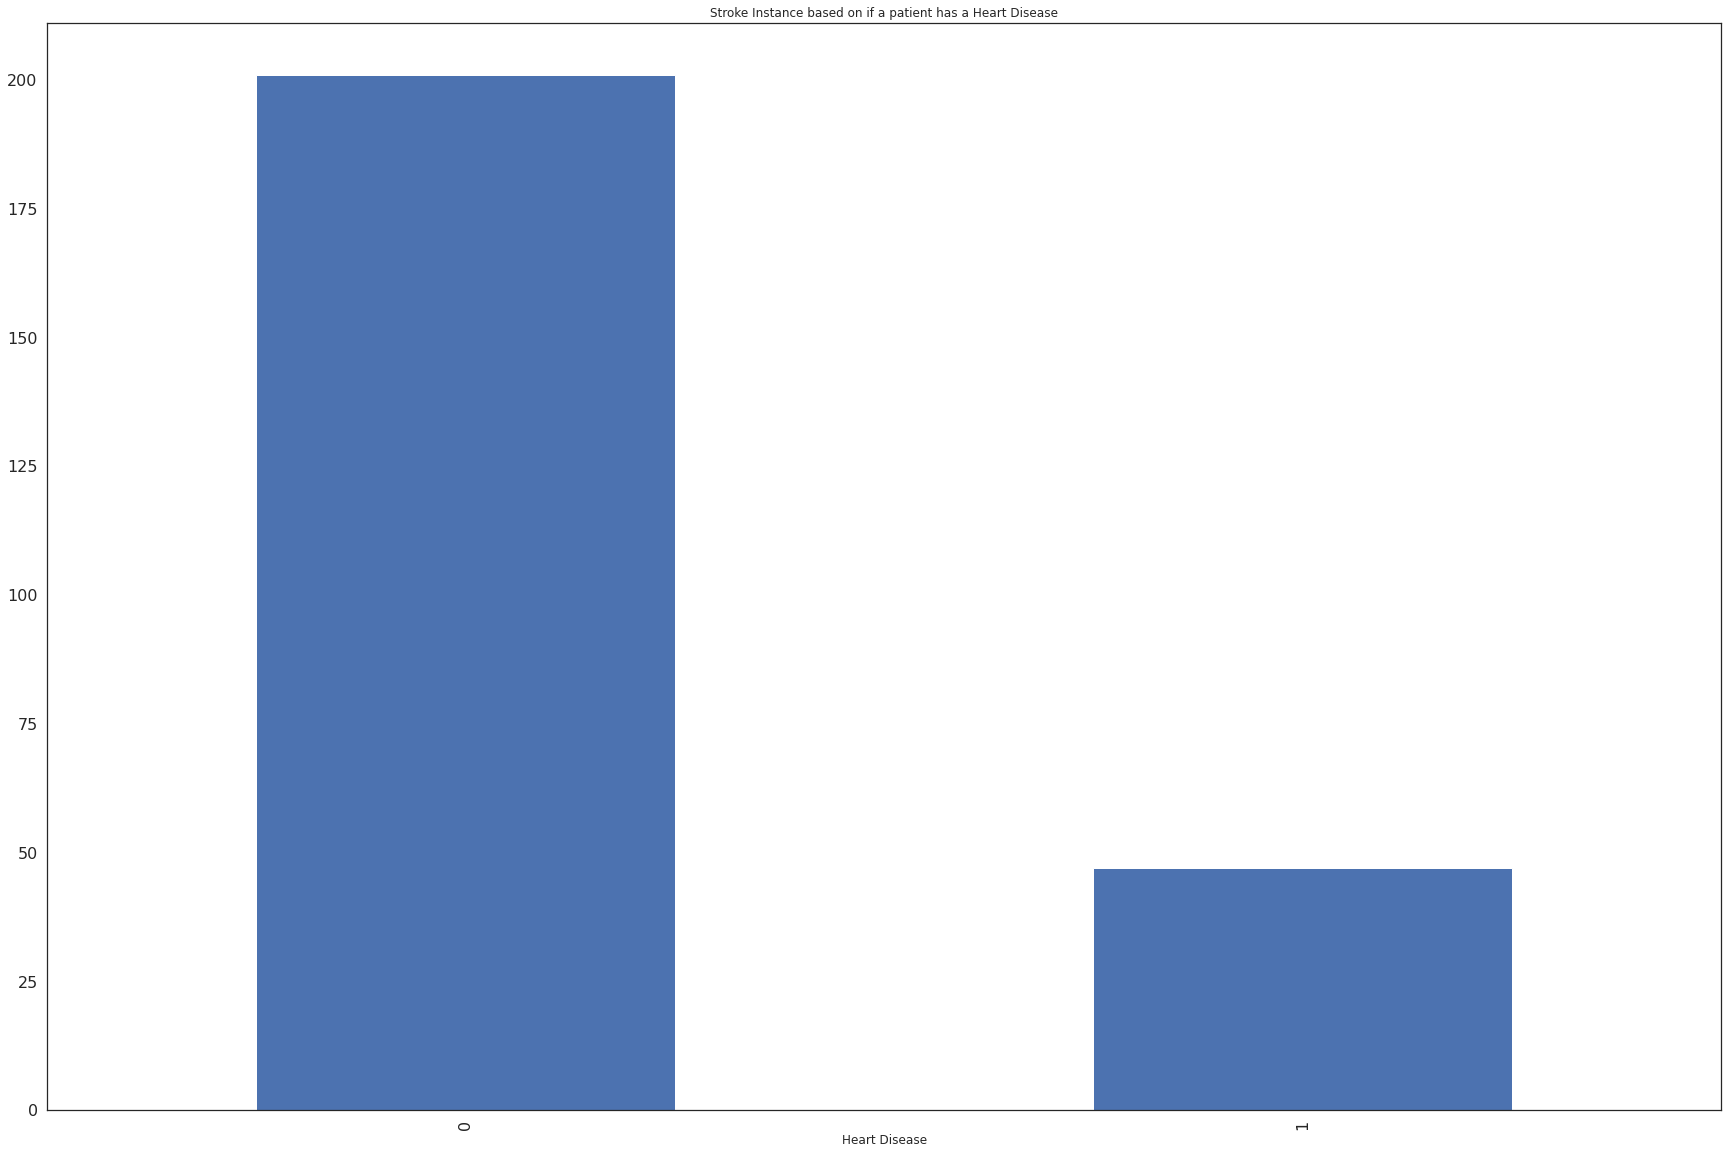

In [28]:
print(brain_train_2.groupby('heart_disease')['stroke'].sum())
brain_train_2.groupby('heart_disease')['stroke'].sum().plot(kind='bar', figsize=(30,20), title="Stroke Instance based on if a patient has a Heart Disease", fontsize=16, xlabel='Heart Disease')

Again, a huge disparity between the frequency of heart disease. Taking the percent!

heart_disease
0     4.271143
1    17.090909
dtype: float64


<AxesSubplot:title={'center':'Stroke Instance Percent based on if a patient has Heart Disease'}, xlabel='Heart Disease'>

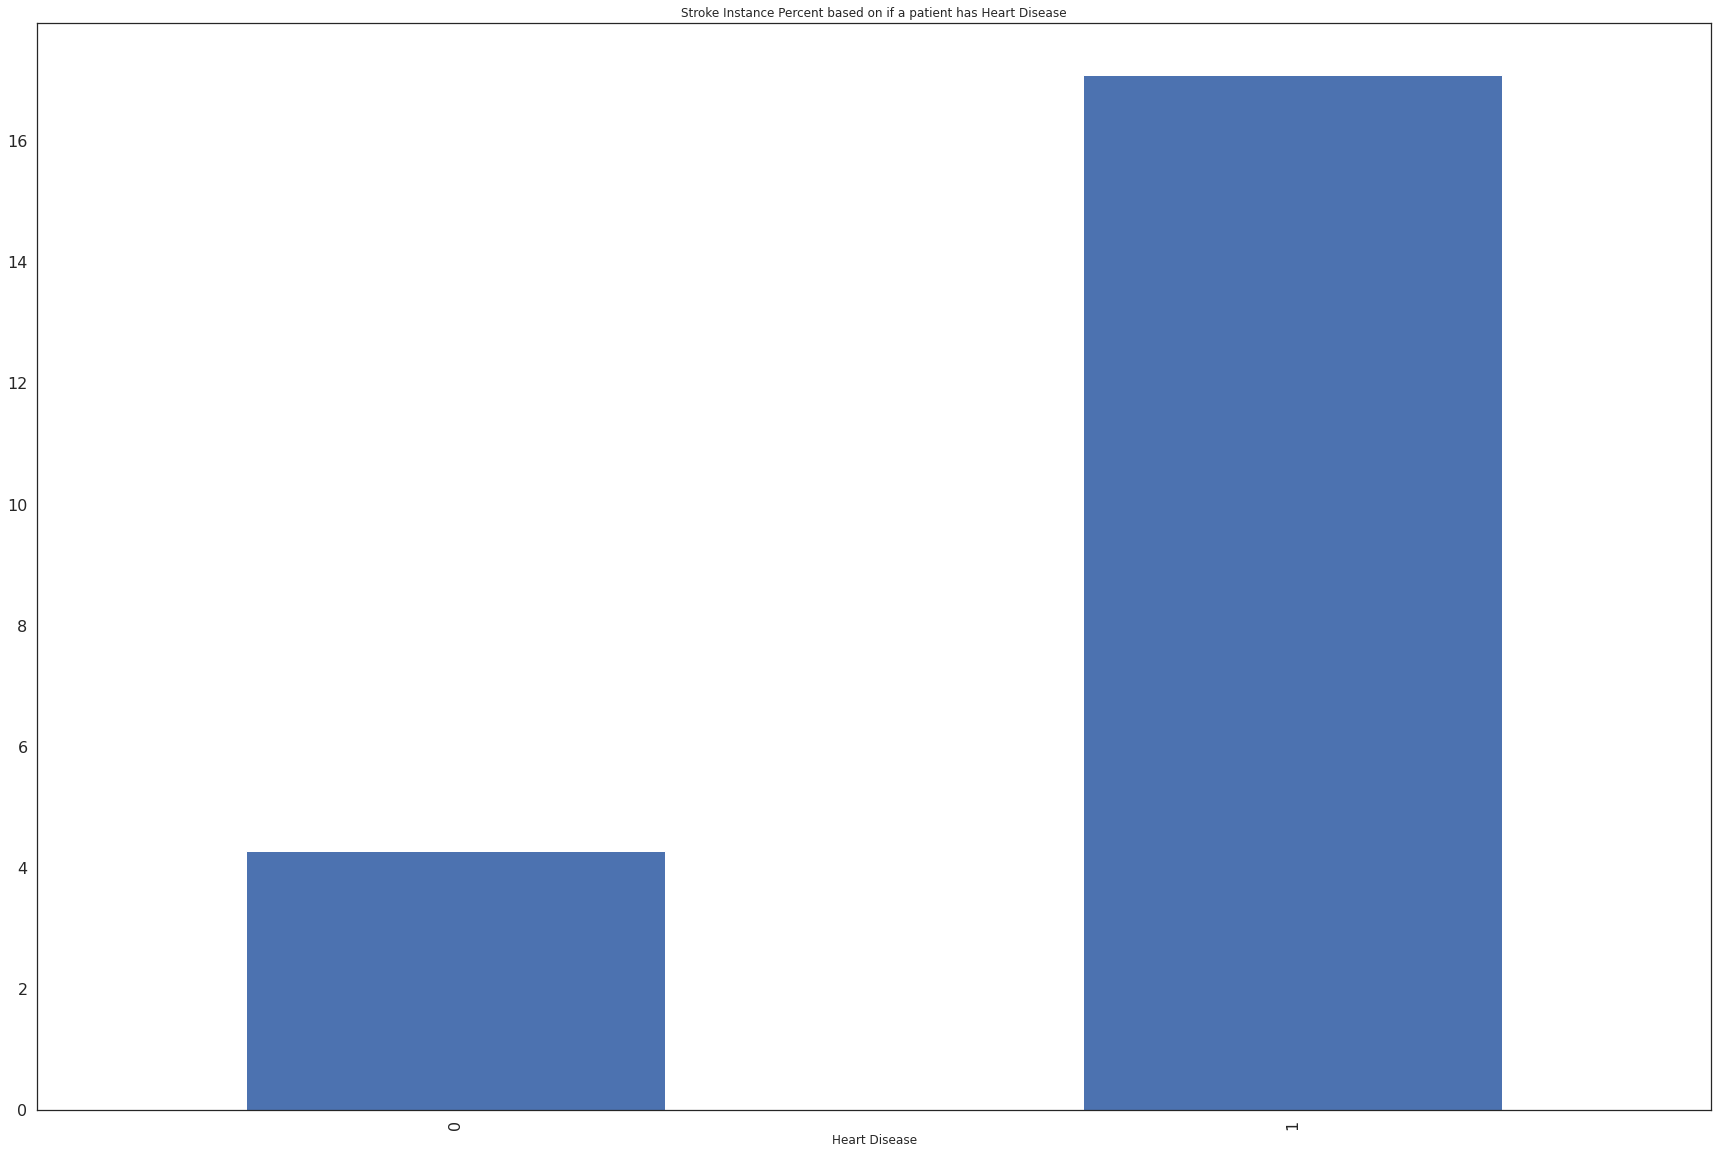

In [29]:
brain_train_3 = (brain_train_2.groupby('heart_disease')['stroke'].sum())/brain_train_2['heart_disease'].value_counts()
brain_train_3 = brain_train_3 * 100
print(brain_train_3)
brain_train_3.plot(kind='bar', figsize=(30,20), title="Stroke Instance Percent based on if a patient has Heart Disease", fontsize=16, xlabel='Heart Disease')

As expected, a whopping 17% of people who had heart disease suffered from a stroke, compared to only 4% of people who didn't have a heart disease.
Heart disease is a factor in determining the occurence of stroke.

For average glucose levels, a bin creation seems to be in order.

The range of bin are actual boundaries for grouping a patient in 'normal', 'pre-diabetic' and 'diabetic' categories. Note these values are for a test done after fasting, which is when a glucose or sugar test would be taken normally.

In [30]:
bins = [0, 100, 125, max(brain_train_2['avg_glucose_level'])]
group_names = ['Normal', 'Pre-Diabetic', 'Diabetic']

brain_train_2['glu-binned'] = pd.cut(brain_train_2['avg_glucose_level'], bins, labels=group_names, include_lowest=True )
brain_train_2[['avg_glucose_level','glu-binned']].head(20)

,avg_glucose_level,glu-binned
0,228.69,Diabetic
1,105.92,Pre-Diabetic
2,171.23,Diabetic
3,174.12,Diabetic
4,186.21,Diabetic
5,70.09,Normal
6,94.39,Normal
7,58.57,Normal
8,80.43,Normal
9,120.46,Pre-Diabetic


In [31]:
brain_train_2['glu-binned'].value_counts()

Normal          3061
Diabetic         964
Pre-Diabetic     956
Name: glu-binned, dtype: int64

glu-binned
Normal          112
Pre-Diabetic     37
Diabetic         99
Name: stroke, dtype: int64


<AxesSubplot:title={'center':'Stroke Instance based on Glucose Levels'}, xlabel='Glucose Level'>

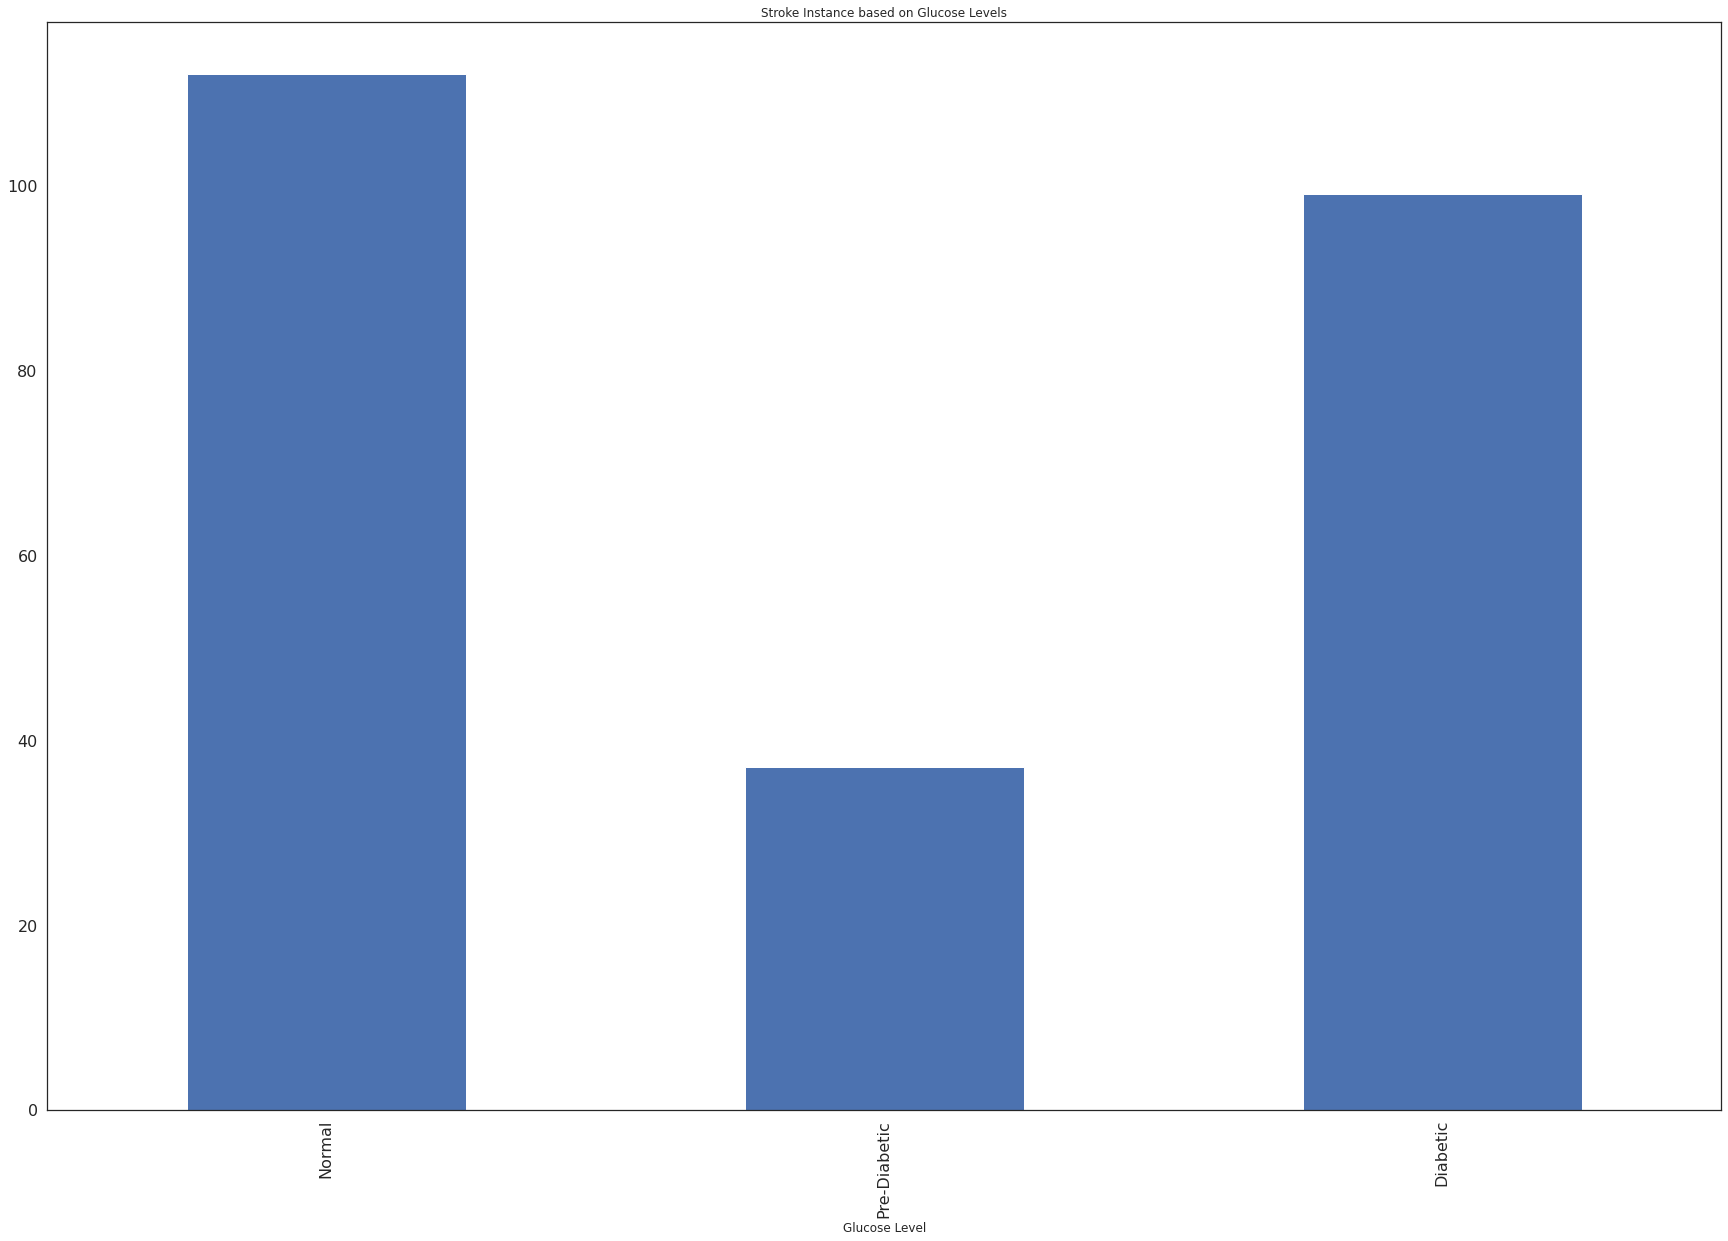

In [32]:
print(brain_train_2.groupby('glu-binned')['stroke'].sum())
brain_train_2.groupby('glu-binned')['stroke'].sum().plot(kind='bar', figsize=(30,20), title="Stroke Instance based on Glucose Levels", fontsize=16, xlabel='Glucose Level')

Again, a huge disparity. Percentage of average glucose level class to the rescue!

Normal           3.658935
Pre-Diabetic     3.870293
Diabetic        10.269710
dtype: float64


<AxesSubplot:title={'center':"Stroke Instance Percent based on a patient's glucose levels"}, xlabel='Glucose Level'>

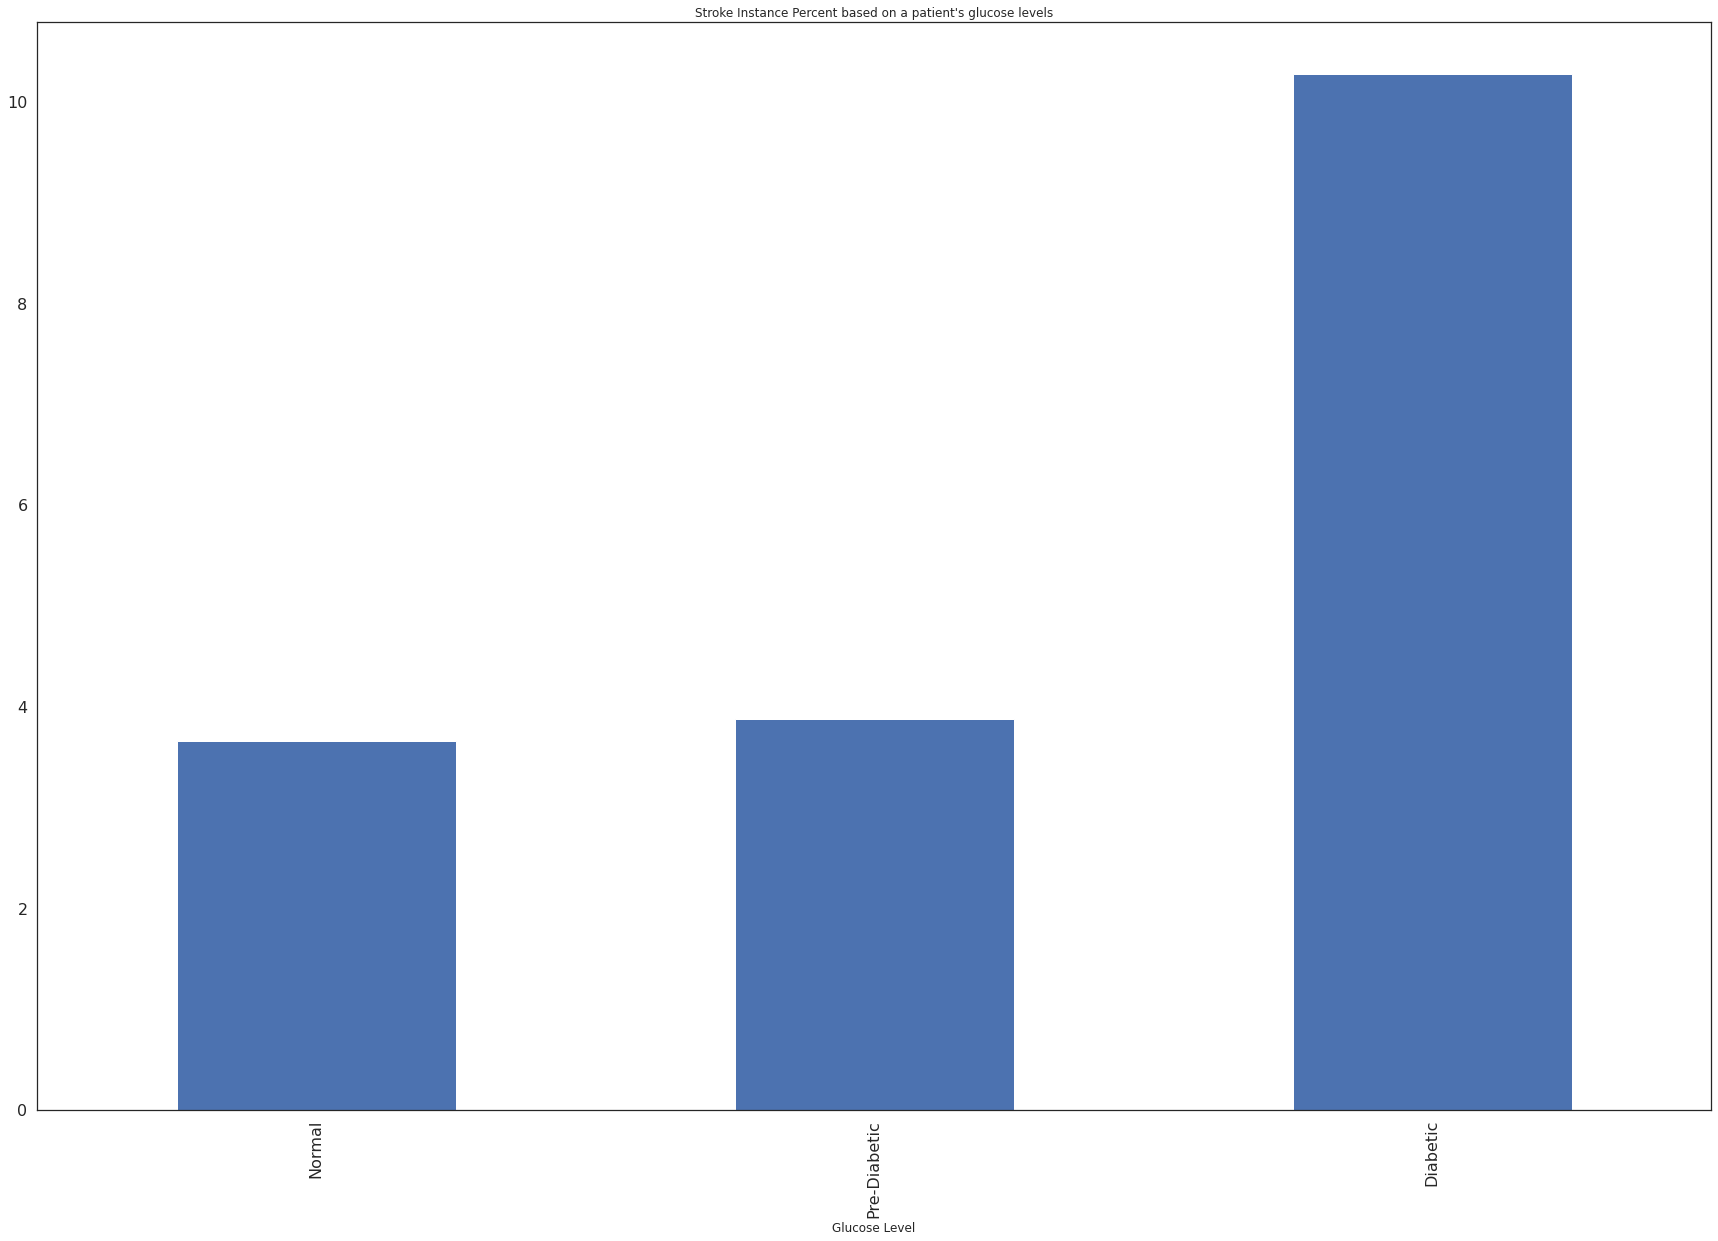

In [33]:
brain_train_3 = (brain_train_2.groupby('glu-binned')['stroke'].sum())/brain_train_2['glu-binned'].value_counts()
brain_train_3 = brain_train_3 * 100
print(brain_train_3)
brain_train_3.plot(kind='bar', figsize=(30,20), title="Stroke Instance Percent based on a patient's glucose levels", fontsize=16, xlabel='Glucose Level')

We can figure out that diabetic patients i.e. patients who have had high glucose levels had higher occurence of stroke at 10.2%

Converting bmi into bins to get a proper idea at the pattern.
Note: the bins are proper bmi boundaries used to find the healthy weight of the patient

In [34]:
bins = [0, 18.5, 25, 30, max(brain_train_2['bmi'])]
group_names = ['Underweight', 'Healthy Weight', 'Overweight', 'Obese']

brain_train_2['bmi_binned'] = pd.cut(brain_train_2['bmi'], bins, labels=group_names, include_lowest=True )
brain_train_2[['bmi','bmi_binned']].head(20)

,bmi,bmi_binned
0,36.6,Obese
1,32.5,Obese
2,34.4,Obese
3,24.0,Healthy Weight
4,29.0,Overweight
5,27.4,Overweight
6,22.8,Healthy Weight
7,24.2,Healthy Weight
8,29.7,Overweight
9,36.8,Obese


In [35]:
brain_train_2['bmi_binned'].value_counts()

Obese             1888
Overweight        1500
Healthy Weight    1261
Underweight        332
Name: bmi_binned, dtype: int64

bmi_binned
Underweight         1
Healthy Weight     38
Overweight        101
Obese             108
Name: stroke, dtype: int64


<AxesSubplot:title={'center':'Stroke Instance based on bmi'}, xlabel='Body Mass Index'>

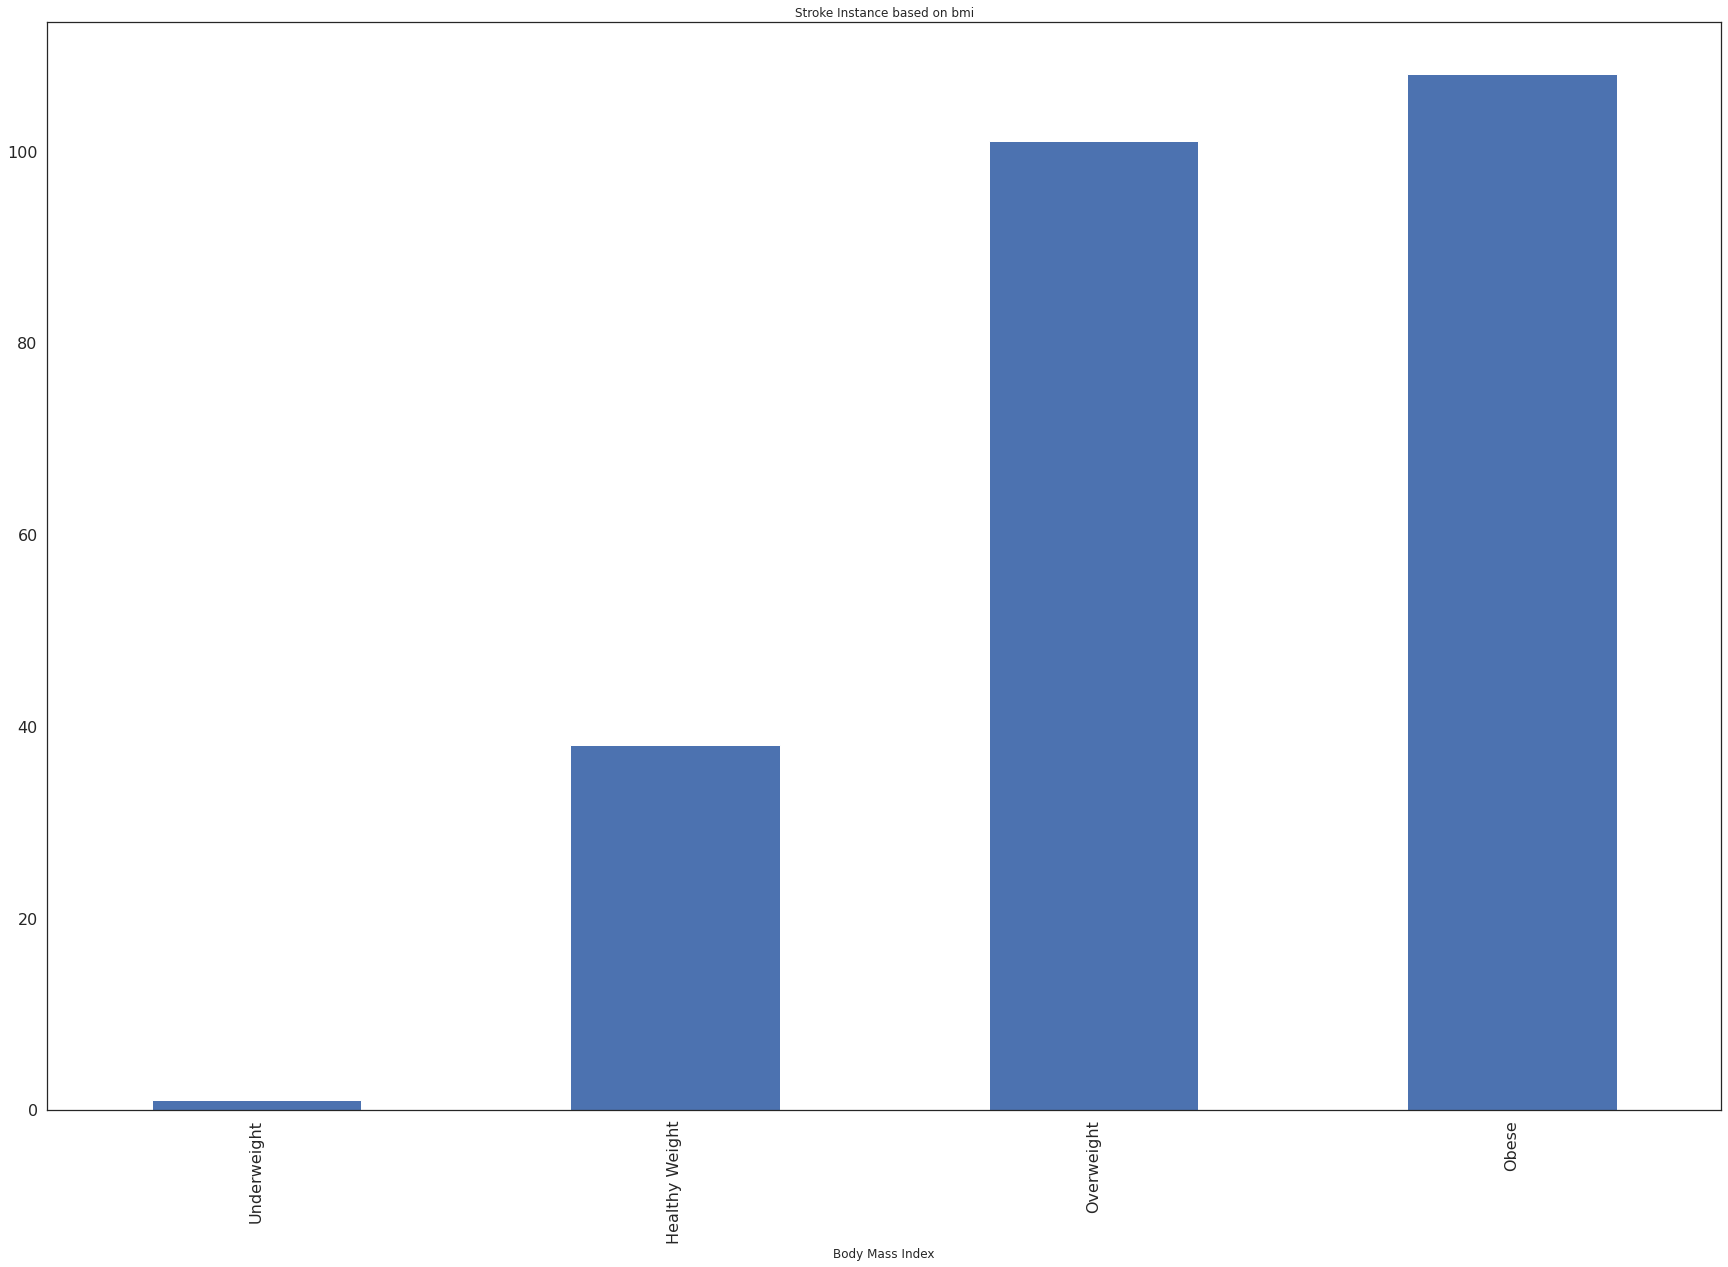

In [36]:
print(brain_train_2.groupby('bmi_binned')['stroke'].sum())
brain_train_2.groupby('bmi_binned')['stroke'].sum().plot(kind='bar', figsize=(30,20), title="Stroke Instance based on bmi", fontsize=16, xlabel='Body Mass Index')

The disparity does not seem to be that big. It seems that the pattern the above graph is showing is quite faithful. But just to be on the safer side, let's take the percent.

Underweight       0.301205
Healthy Weight    3.013481
Overweight        6.733333
Obese             5.720339
dtype: float64


<AxesSubplot:title={'center':"Stroke Instance Percent based on a patient's bmi"}, xlabel='Body Mass Index'>

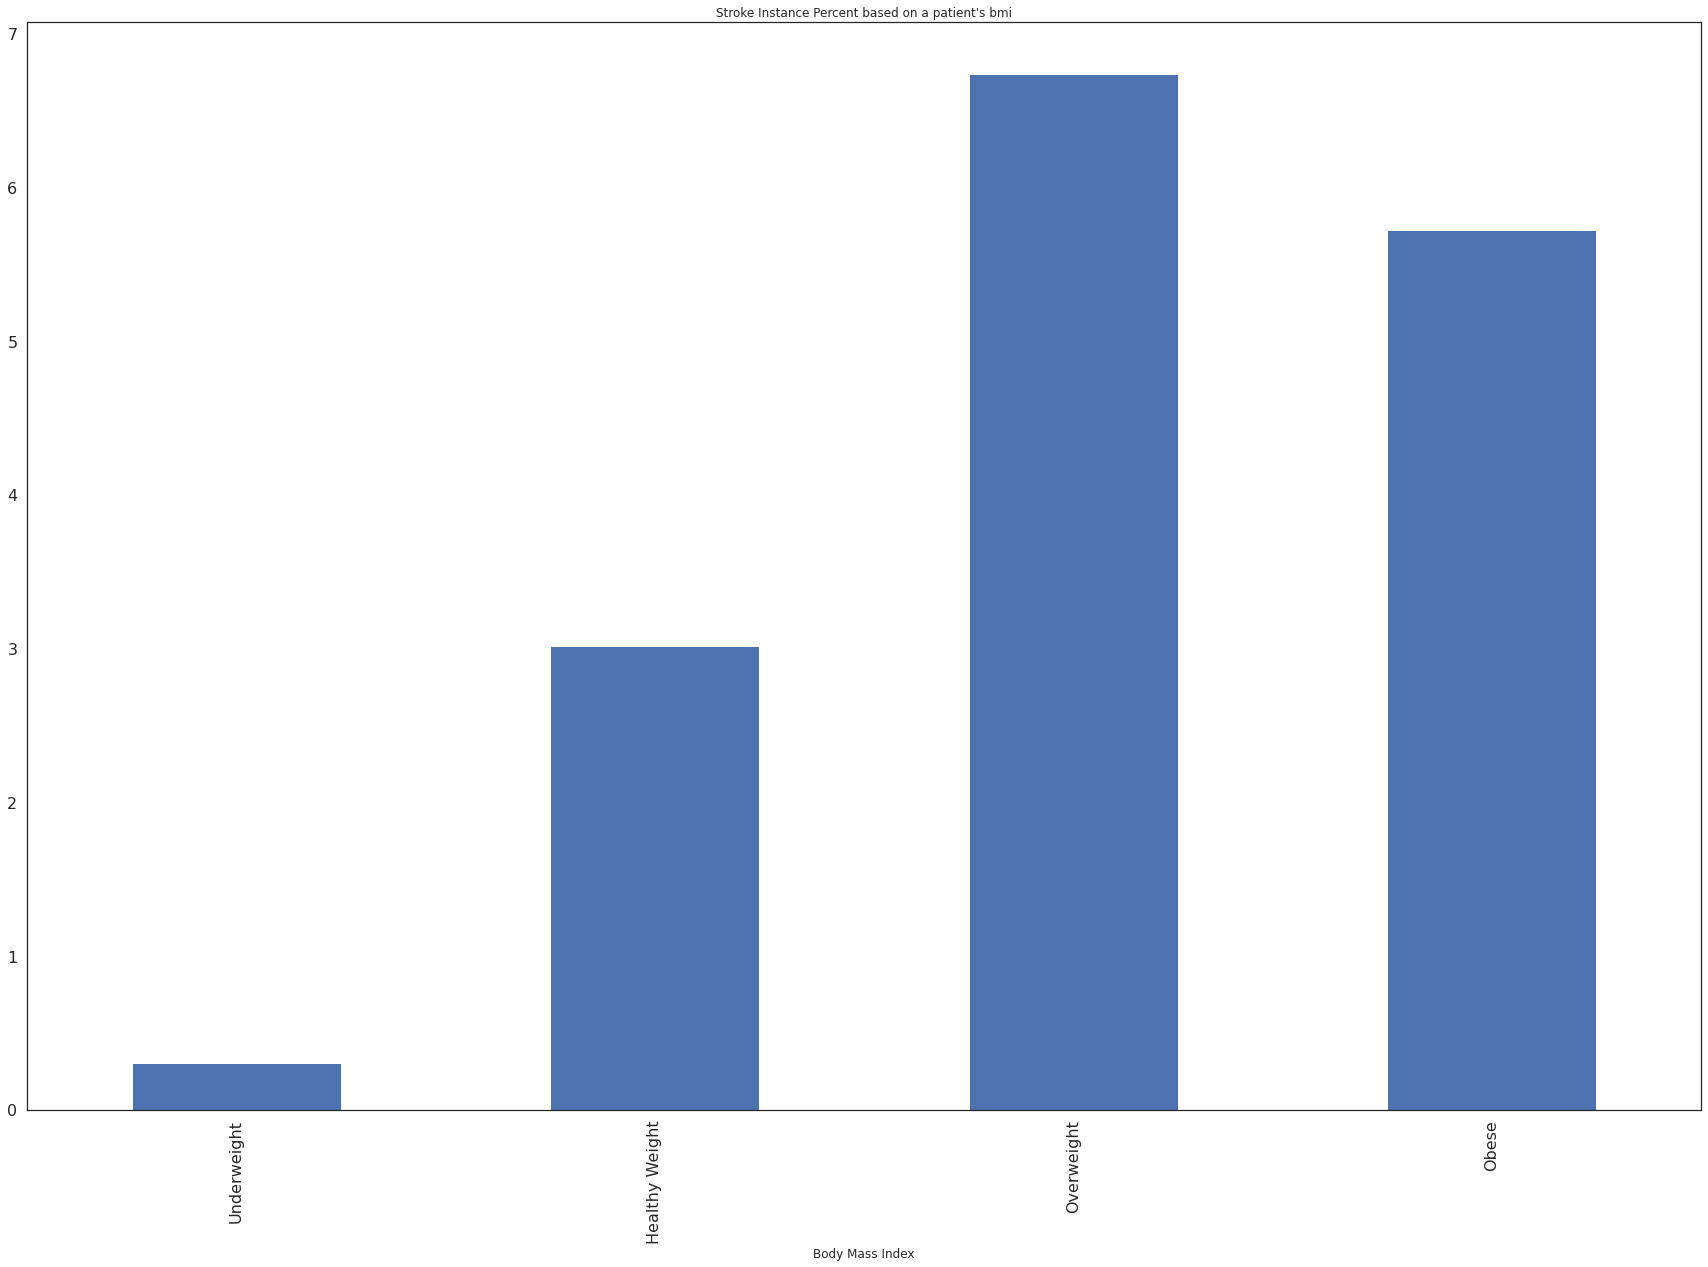

In [37]:
brain_train_3 = (brain_train_2.groupby('bmi_binned')['stroke'].sum())/brain_train_2['bmi_binned'].value_counts()
brain_train_3 = brain_train_3 * 100
print(brain_train_3)
brain_train_3.plot(kind='bar', figsize=(30,20), title="Stroke Instance Percent based on a patient's bmi", fontsize=16, xlabel='Body Mass Index')

As expected the frequency graph gave an almost faithful result. However, it can be noticed the difference in percent is quite low. So it seems that bmi might not be that good of a factor.

To confirm if 'bmi' should be included as a factor, a f test is in order!

In [38]:
grouped_test2=brain_train_2[['bmi', 'stroke']].groupby(['stroke'])
grouped_test2.head(2)
f_val, p_val = stats.f_oneway(grouped_test2.get_group(0)['bmi'], grouped_test2.get_group(1)['bmi'])  
print( "ANOVA results: F=", f_val, ", P =", p_val) 

ANOVA results: F= 16.187058929050675 , P = 5.823561265136435e-05


Since the p-value for bmi is 5.___ *10^-5, bmi does seem to be important and we can reject the null hypothesis for it as p value < 0.05.

Now converting the 'ever married', 'work_type', 'Residence_type', 'smoking_status' to int as it would be much better for our ML algorithm to deal with. Label encoding is used from sklearn.

In [39]:
oe = OrdinalEncoder()
cat_cols = ['ever_married', 'work_type', 'Residence_type', 'smoking_status', 'gender']
for i in cat_cols:
    brain_train_2[i] = oe.fit_transform(brain_train_2[[i]]).astype(int)
brain_train_2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age-binned,glu-binned,bmi_binned
0,1,67,0,1,1,1,1,228.69,36.6,1,1,Old,Diabetic,Obese
1,1,80,0,1,1,1,0,105.92,32.5,2,1,Old,Pre-Diabetic,Obese
2,0,49,0,0,1,1,1,171.23,34.4,3,1,Prime,Diabetic,Obese
3,0,79,1,0,1,2,0,174.12,24.0,2,1,Old,Diabetic,Healthy Weight
4,1,81,0,0,1,1,1,186.21,29.0,1,1,Old,Diabetic,Overweight


0    2907
1    2074
Name: gender, dtype: int64
gender
0    140
1    108
Name: stroke, dtype: int64


<AxesSubplot:title={'center':'Stroke Instance based on Gender'}, xlabel='Gender'>

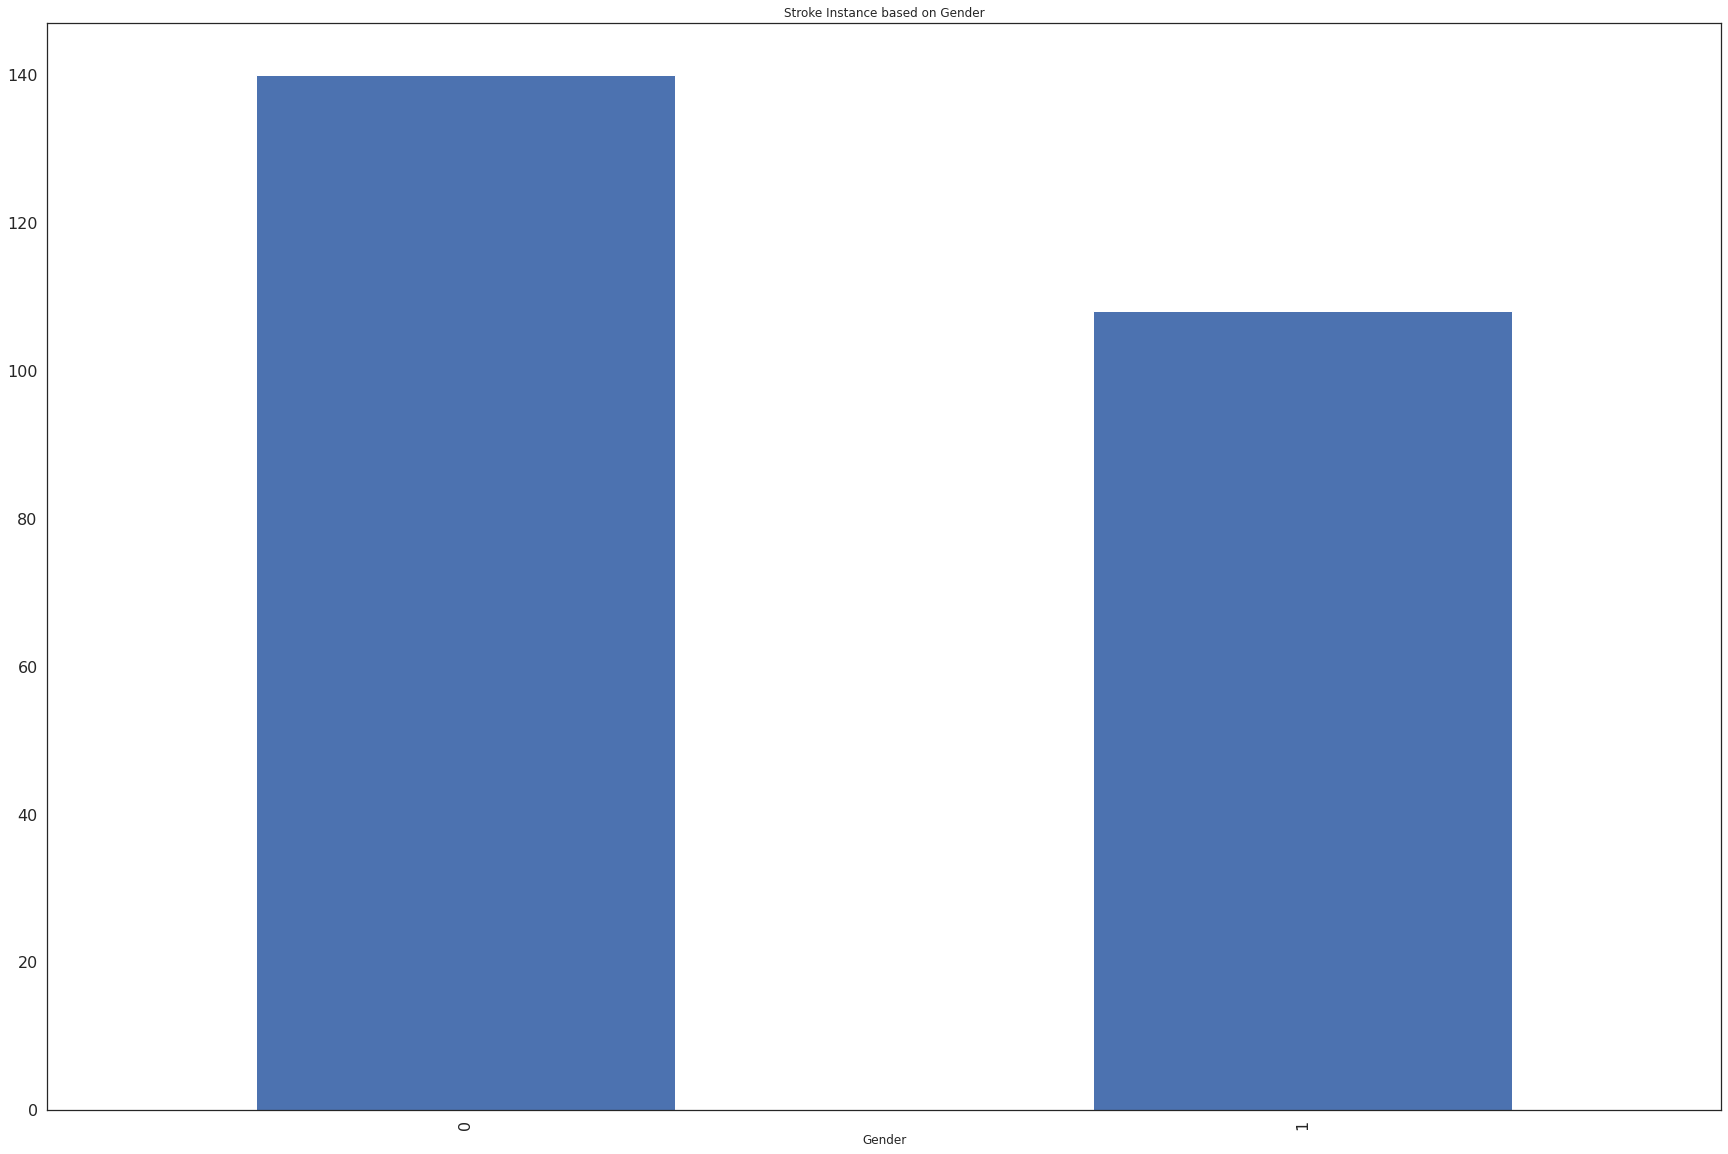

In [40]:
print(brain_train_2['gender'].value_counts())
print(brain_train_2.groupby('gender')['stroke'].sum())
brain_train_2.groupby('gender')['stroke'].sum().plot(kind='bar', figsize=(30,20), title="Stroke Instance based on Gender", fontsize=16, xlabel='Gender')

There doesn't seem to be much of a difference. Let's take a look at percentages!

gender
0    4.815961
1    5.207329
dtype: float64


<AxesSubplot:title={'center':'Stroke Instance Percent based on Gender'}, xlabel='Gender'>

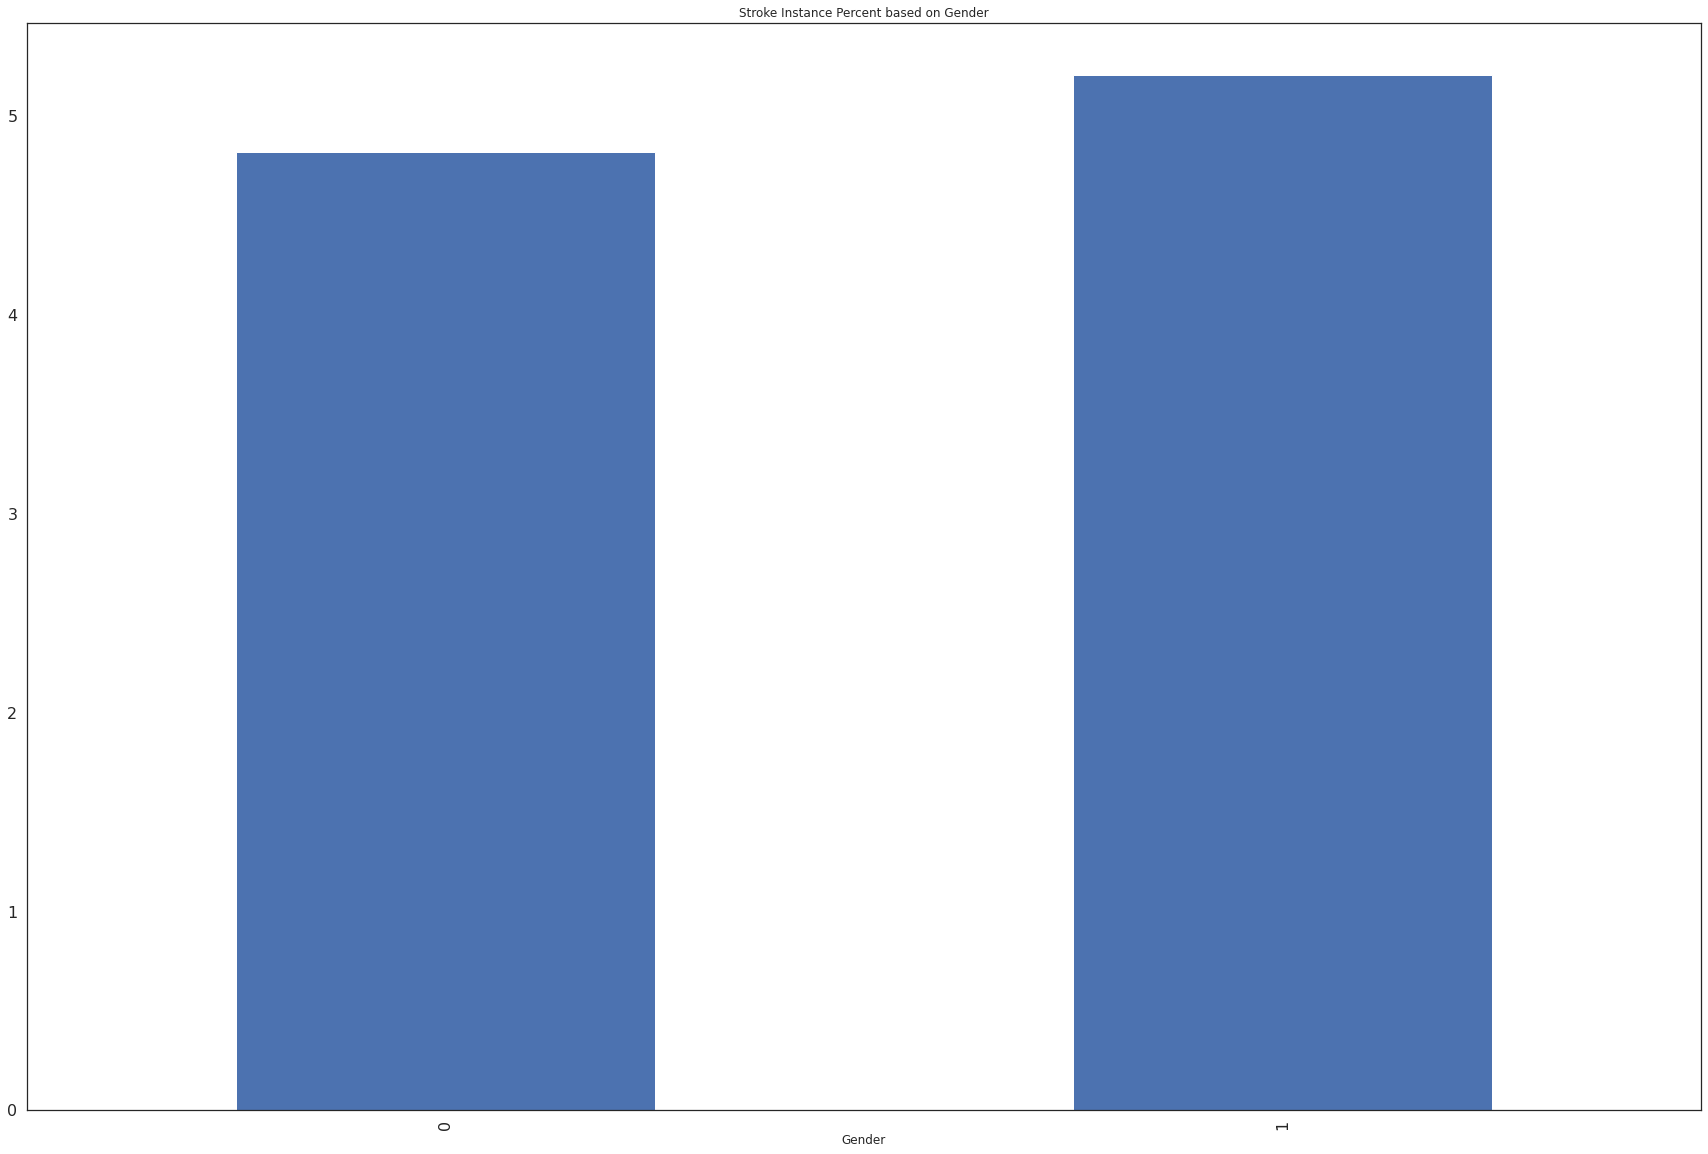

In [41]:
brain_train_3 = (brain_train_2.groupby('gender')['stroke'].sum())/brain_train_2['gender'].value_counts()
brain_train_3 = brain_train_3 * 100
print(brain_train_3)
brain_train_3.plot(kind='bar', figsize=(30,20), title="Stroke Instance Percent based on Gender", fontsize=16, xlabel='Gender')

Hmm, there doesn't seem to be any pattern that we can use to consider if gender is a factor for deciding the occurence of stroke.

Now finding out if we should proceed with the proper age, bmi and average glucose level or should we consider their binned counterparts to be a better factors. Lets go for the binned values!

In [42]:
binned_cols = ['age-binned', 'glu-binned', 'bmi_binned']
for i in binned_cols:
    brain_train_2[i] = oe.fit_transform(brain_train_2[[i]]).astype(int)
    grouped_test2=brain_train_2[[i, 'stroke']].groupby(['stroke'])
    grouped_test2.head(2)
    f_val, p_val = stats.f_oneway(grouped_test2.get_group(0)[i], grouped_test2.get_group(1)[i])  
    print( "ANOVA results for", i, ": F=", f_val, ", P =", p_val) 

ANOVA results for age-binned : F= 142.96722333765362 , P = 1.6591451885080162e-32
ANOVA results for glu-binned : F= 42.11290731462979 , P = 9.452269435365726e-11
ANOVA results for bmi_binned : F= 2.1627056149402044 , P = 0.14145871888626305


In [43]:
normal_cols = ['age', 'avg_glucose_level', 'bmi']
for i in normal_cols:
    grouped_test3=brain_train_2[[i, 'stroke']].groupby(['stroke'])
    grouped_test3.head(2)
    f_val, p_val = stats.f_oneway(grouped_test3.get_group(0)[i], grouped_test3.get_group(1)[i])  
    print( "ANOVA results for", i, ": F=", f_val, ", P =", p_val) 

ANOVA results for age : F= 321.68641894679877 , P = 9.353763403657433e-70
ANOVA results for avg_glucose_level : F= 89.97181953814096 , P = 3.642050793086219e-21
ANOVA results for bmi : F= 16.187058929050675 , P = 5.823561265136435e-05


Nope, normal columns are far better predictors judging from the ANOVA results. However, should they be considered for the model?

And finally let's take a count of what columns to use for predictors.

In [44]:
brain_train_2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age-binned,glu-binned,bmi_binned
0,1,67,0,1,1,1,1,228.69,36.6,1,1,1,0,1
1,1,80,0,1,1,1,0,105.92,32.5,2,1,1,2,1
2,0,49,0,0,1,1,1,171.23,34.4,3,1,2,0,1
3,0,79,1,0,1,2,0,174.12,24.0,2,1,1,0,0
4,1,81,0,0,1,1,1,186.21,29.0,1,1,1,0,2


In [45]:
predictor_cols = []
for i in brain_train_2.drop(columns=['stroke']):
    grouped_test4=brain_train_2[[i, 'stroke']].groupby(['stroke'])
    f_val, p_val = stats.f_oneway(grouped_test4.get_group(0)[i], grouped_test4.get_group(1)[i])  
    print( "ANOVA results for", i, ": F=", f_val, ", P =", p_val) 
    if p_val < 0.05:
        predictor_cols.append(i)
print("Predictor columns are :", predictor_cols)

ANOVA results for gender : F= 0.3917518909649996 , P = 0.5314086575475605
ANOVA results for age : F= 321.68641894679877 , P = 9.353763403657433e-70
ANOVA results for hypertension : F= 88.24518865551374 , P = 8.584820646978981e-21
ANOVA results for heart_disease : F= 91.88408648440968 , P = 1.4098084414515118e-21
ANOVA results for ever_married : F= 59.19960503044742 , P = 1.7063558366180235e-14
ANOVA results for work_type : F= 8.729183621193947 , P = 0.00314623279927832
ANOVA results for Residence_type : F= 1.354940194295431 , P = 0.2444720927935498
ANOVA results for avg_glucose_level : F= 89.97181953814096 , P = 3.642050793086219e-21
ANOVA results for bmi : F= 16.187058929050675 , P = 5.823561265136435e-05
ANOVA results for smoking_status : F= 3.758130554304336 , P = 0.052607746648011676
ANOVA results for age-binned : F= 142.96722333765362 , P = 1.6591451885080162e-32
ANOVA results for glu-binned : F= 42.11290731462979 , P = 9.452269435365726e-11
ANOVA results for bmi_binned : F= 2.162

So the results are out, the columns that will be used for stroke prediction are 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'avg_glucose_level', 'bmi' and 'smoking_status'
Now if you notice, it will be found that smoking status while not really cutting it, is right on the cusp with a p_value of 0.052 and hence we would take it into consideration.

In [46]:
brain_train.drop(columns=['age-binned'], inplace=True)

In [47]:
for i in cat_cols:
    brain_train[i] = oe.fit_transform(brain_train[[i]]).astype(int)

Now that the dataset is in the form that looks great, let's move on to modelling!

In [48]:
predictor_brain_train = predictor_cols.remove('age-binned')
predictor_brain_train = predictor_cols.remove('glu-binned')

In [49]:
y_data = brain_train['stroke']
x_data = brain_train[predictor_cols]

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1)
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 499
number of training samples: 4482


Hold on! It seems that there is a huge imbalance in the data. 

In [51]:
print(brain_train['stroke'].sum())
print(brain_train['stroke'].shape)

248
(4981,)


Indeed! Only 248 belong to one class out of 4981! Oversampling to the rescue! SMOTE it! 

In [52]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_train, y_train)
print(x_smote.shape, y_smote.shape, x_data.shape, y_data.shape)

(8514, 7) (8514,) (4981, 7) (4981,)


And SMOTE has done it again. 

Now loading the parameters for each of the machine learning algorithm that will be used i.e. logistic regression, xgb classifier, random forest, naive bayes and svc.

In [53]:
log_reg_params = [{"C":0.01, "solver":"newton-cg"}, {"C":0.1, "solver":"newton-cg"}, {"C":1, "solver":"newton-cg"}, {"C":10, "solver":"newton-cg"}]
xgb_class_params = [{"eta":0.01}, {"eta":0.03}, {"eta":0.05}, {"eta":0.10}, {"eta":0.3}, {"eta":0.05}, {"eta":0.05, "sampling_method":"gradient_based"}, {"eta":0.08}, {"eta":0.08, "sampling_method":"gradient_based", "n_estimators": 1200}, {"sampling_method": "uniform"}, {"sampling_method": "gradient_based"}, {"n_estimators": 300}, {"n_estimators": 500}, {"n_estimators": 800}, {"n_estimators": 1000}, {"n_estimators": 1200}]
rand_for_params = [{"criterion": "gini"}, {"criterion": "entropy"}]
naive_bayes_params = [{}]
svc_params = [{"C":0.01}, {"C":0.1}, {"C":1}, {"C":10}, {"C":15}]

In [54]:
modelclasses = [
    ["log regression", LogisticRegression, log_reg_params],
    ["XGBoost", XGBClassifier, xgb_class_params],
    ["random forest", RandomForestClassifier, rand_for_params],
    ["naive bayes", GaussianNB, naive_bayes_params],
    ["support vector machines", SVC, svc_params]
]

In [55]:
insights = []
conf_mats = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        model.fit(x_smote, y_smote)
        score = model.score(x_test, y_test)
        preds = model.predict(x_test)
        conf_matrix = confusion_matrix(y_test, preds)
        conf_mats.append((modelname, model, conf_matrix, params))
        insights.append((modelname, model, params, score))

In [56]:
insights.sort(key=lambda x:x[-1], reverse=True)
for modelname, model, params, score in insights:
    print(modelname, params, score)

XGBoost {'n_estimators': 1200} 0.8957915831663327
XGBoost {'n_estimators': 500} 0.8917835671342685
XGBoost {'n_estimators': 800} 0.8917835671342685
XGBoost {'n_estimators': 1000} 0.8917835671342685
XGBoost {'eta': 0.08, 'sampling_method': 'gradient_based', 'n_estimators': 1200} 0.8897795591182365
XGBoost {'n_estimators': 300} 0.8777555110220441
random forest {'criterion': 'gini'} 0.875751503006012
random forest {'criterion': 'entropy'} 0.875751503006012
XGBoost {'eta': 0.3} 0.8637274549098196
XGBoost {'sampling_method': 'uniform'} 0.8637274549098196
XGBoost {'sampling_method': 'gradient_based'} 0.8637274549098196
XGBoost {'eta': 0.08} 0.8316633266533067
XGBoost {'eta': 0.1} 0.8296593186372746
XGBoost {'eta': 0.03} 0.8076152304609219
XGBoost {'eta': 0.05} 0.8076152304609219
XGBoost {'eta': 0.05} 0.8076152304609219
XGBoost {'eta': 0.05, 'sampling_method': 'gradient_based'} 0.8076152304609219
log regression {'C': 0.01, 'solver': 'newton-cg'} 0.7755511022044088
log regression {'C': 0.1, 's

We got the ranks!
Now this is all fine and good, however, if we want to find out how well our models performed, we need to look at the confusion matrix. 

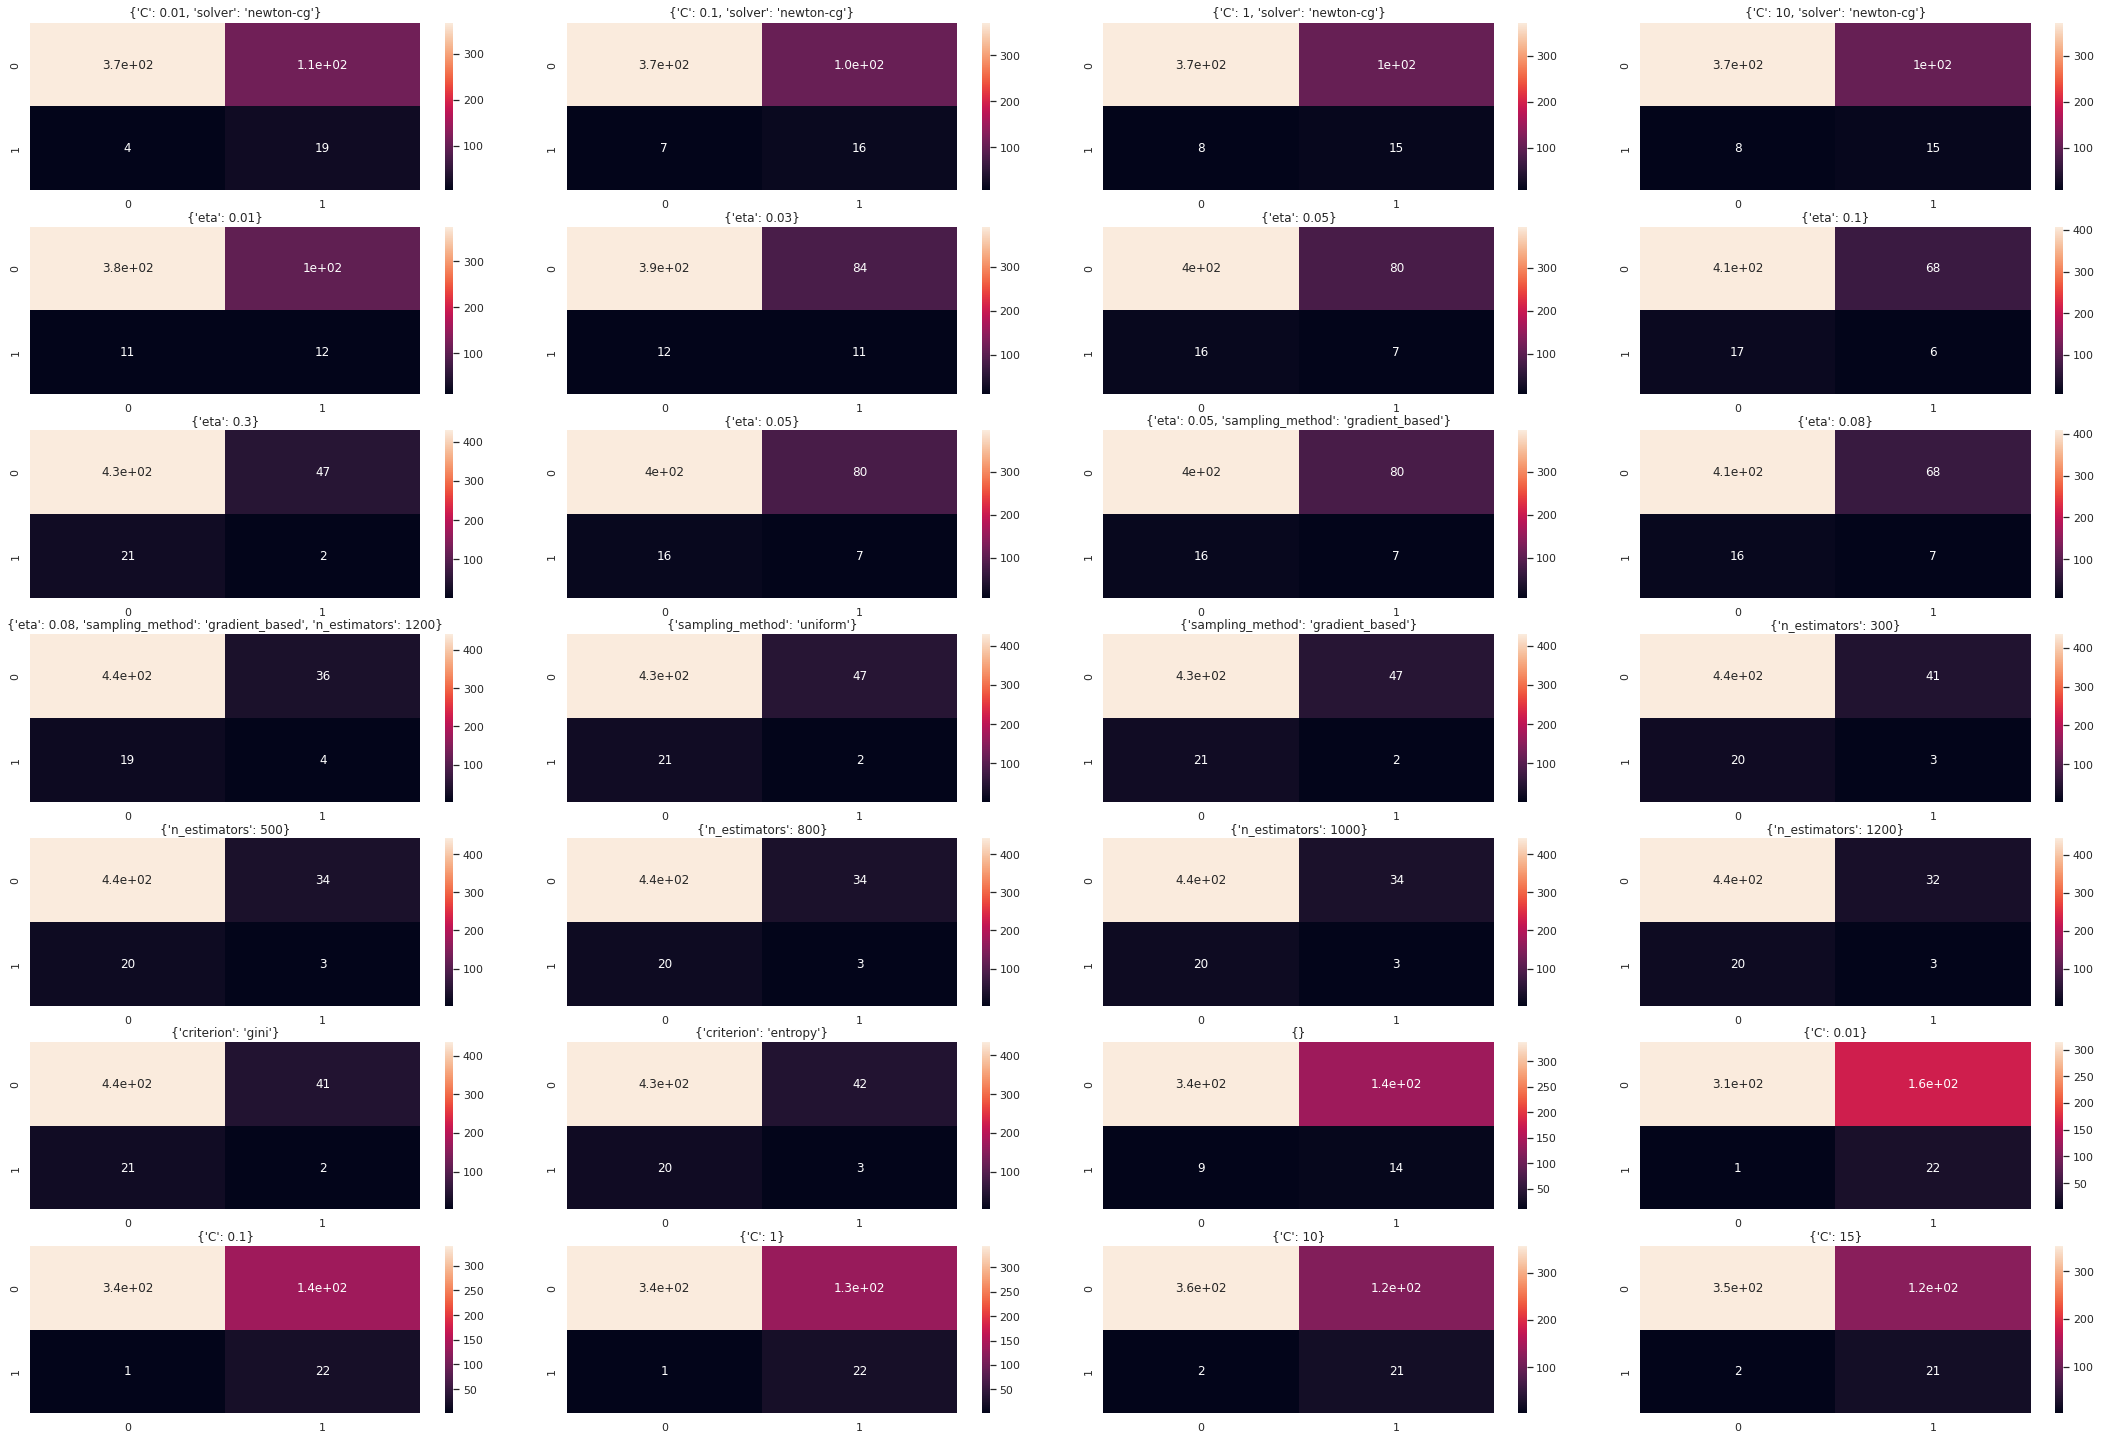

In [57]:
fig, axes = plt.subplots(7, 4)
k = 0
plt.tight_layout()
for i in range(7):
    for j in range(4):
        axes[i,j].set_title(conf_mats[k][3])
        sns.heatmap(conf_mats[k][2], annot=True, ax=axes[i,j])
        k = k+1

As we can observe from the confusion matrix heatmap, the model that is performing well i.e. XGBoost with n-estimators: 800 and 1000 have a high false positive and false negative rate. Whereas only a small true positves are detected. Can this model be improved by adding those glu-binned and age-binned features? Let's find out!

In [58]:
predcols = predictor_cols.copy()
predcols.append('age-binned')
predcols.append('glu-binned')
predcols

['age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'avg_glucose_level',
 'bmi',
 'age-binned',
 'glu-binned']

In [66]:
predcols.remove('age')
predcols.remove('avg_glucose_level')
predcols

ValueError: list.remove(x): x not in list

In [67]:
predcols

['hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'bmi',
 'age-binned',
 'glu-binned']

The same process again: splitting, SMOTEing and running it through various models.

In [68]:
y_data_2 = brain_train_2['stroke']
x_data_2 = brain_train_2[predcols]

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_data, y_data, test_size=0.10, random_state=1)
print("number of test samples :", x_test_2.shape[0])
print("number of training samples:",x_train_2.shape[0])

number of test samples : 499
number of training samples: 4482


In [69]:
x_smote_2, y_smote_2 = smote.fit_resample(x_train, y_train)
print(x_smote_2.shape, y_smote_2.shape, x_data_2.shape, y_data_2.shape)

(8514, 7) (8514,) (4981, 7) (4981,)


In [70]:
insights_2 = []
conf_mats_2 = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        model.fit(x_smote_2, y_smote_2)
        score = model.score(x_test_2, y_test_2) 
        preds_2 = model.predict(x_test_2)
        conf_matrix_2 = confusion_matrix(y_test_2, preds_2)
        conf_mats_2.append((modelname, model, conf_matrix_2, params))
        insights_2.append((modelname, model, params, score))

In [71]:
insights_2.sort(key=lambda x:x[-1], reverse=True)
for modelname, model, params, score in insights_2:
    print(modelname, params, score)

XGBoost {'n_estimators': 500} 0.9078156312625251
XGBoost {'n_estimators': 300} 0.905811623246493
XGBoost {'n_estimators': 800} 0.9038076152304609
XGBoost {'n_estimators': 1000} 0.9018036072144289
XGBoost {'n_estimators': 1200} 0.9018036072144289
XGBoost {'eta': 0.08, 'sampling_method': 'gradient_based', 'n_estimators': 1200} 0.8817635270541082
random forest {'criterion': 'gini'} 0.8797595190380761
random forest {'criterion': 'entropy'} 0.875751503006012
XGBoost {'eta': 0.3} 0.8717434869739479
XGBoost {'sampling_method': 'uniform'} 0.8717434869739479
XGBoost {'sampling_method': 'gradient_based'} 0.8717434869739479
XGBoost {'eta': 0.1} 0.843687374749499
XGBoost {'eta': 0.08} 0.8376753507014028
XGBoost {'eta': 0.05} 0.8236472945891784
XGBoost {'eta': 0.05} 0.8236472945891784
XGBoost {'eta': 0.05, 'sampling_method': 'gradient_based'} 0.8236472945891784
XGBoost {'eta': 0.03} 0.8056112224448898
log regression {'C': 0.1, 'solver': 'newton-cg'} 0.7775551102204409
log regression {'C': 1, 'solve

Aha! There is a minor improvement in the performance. We will take that as a win.

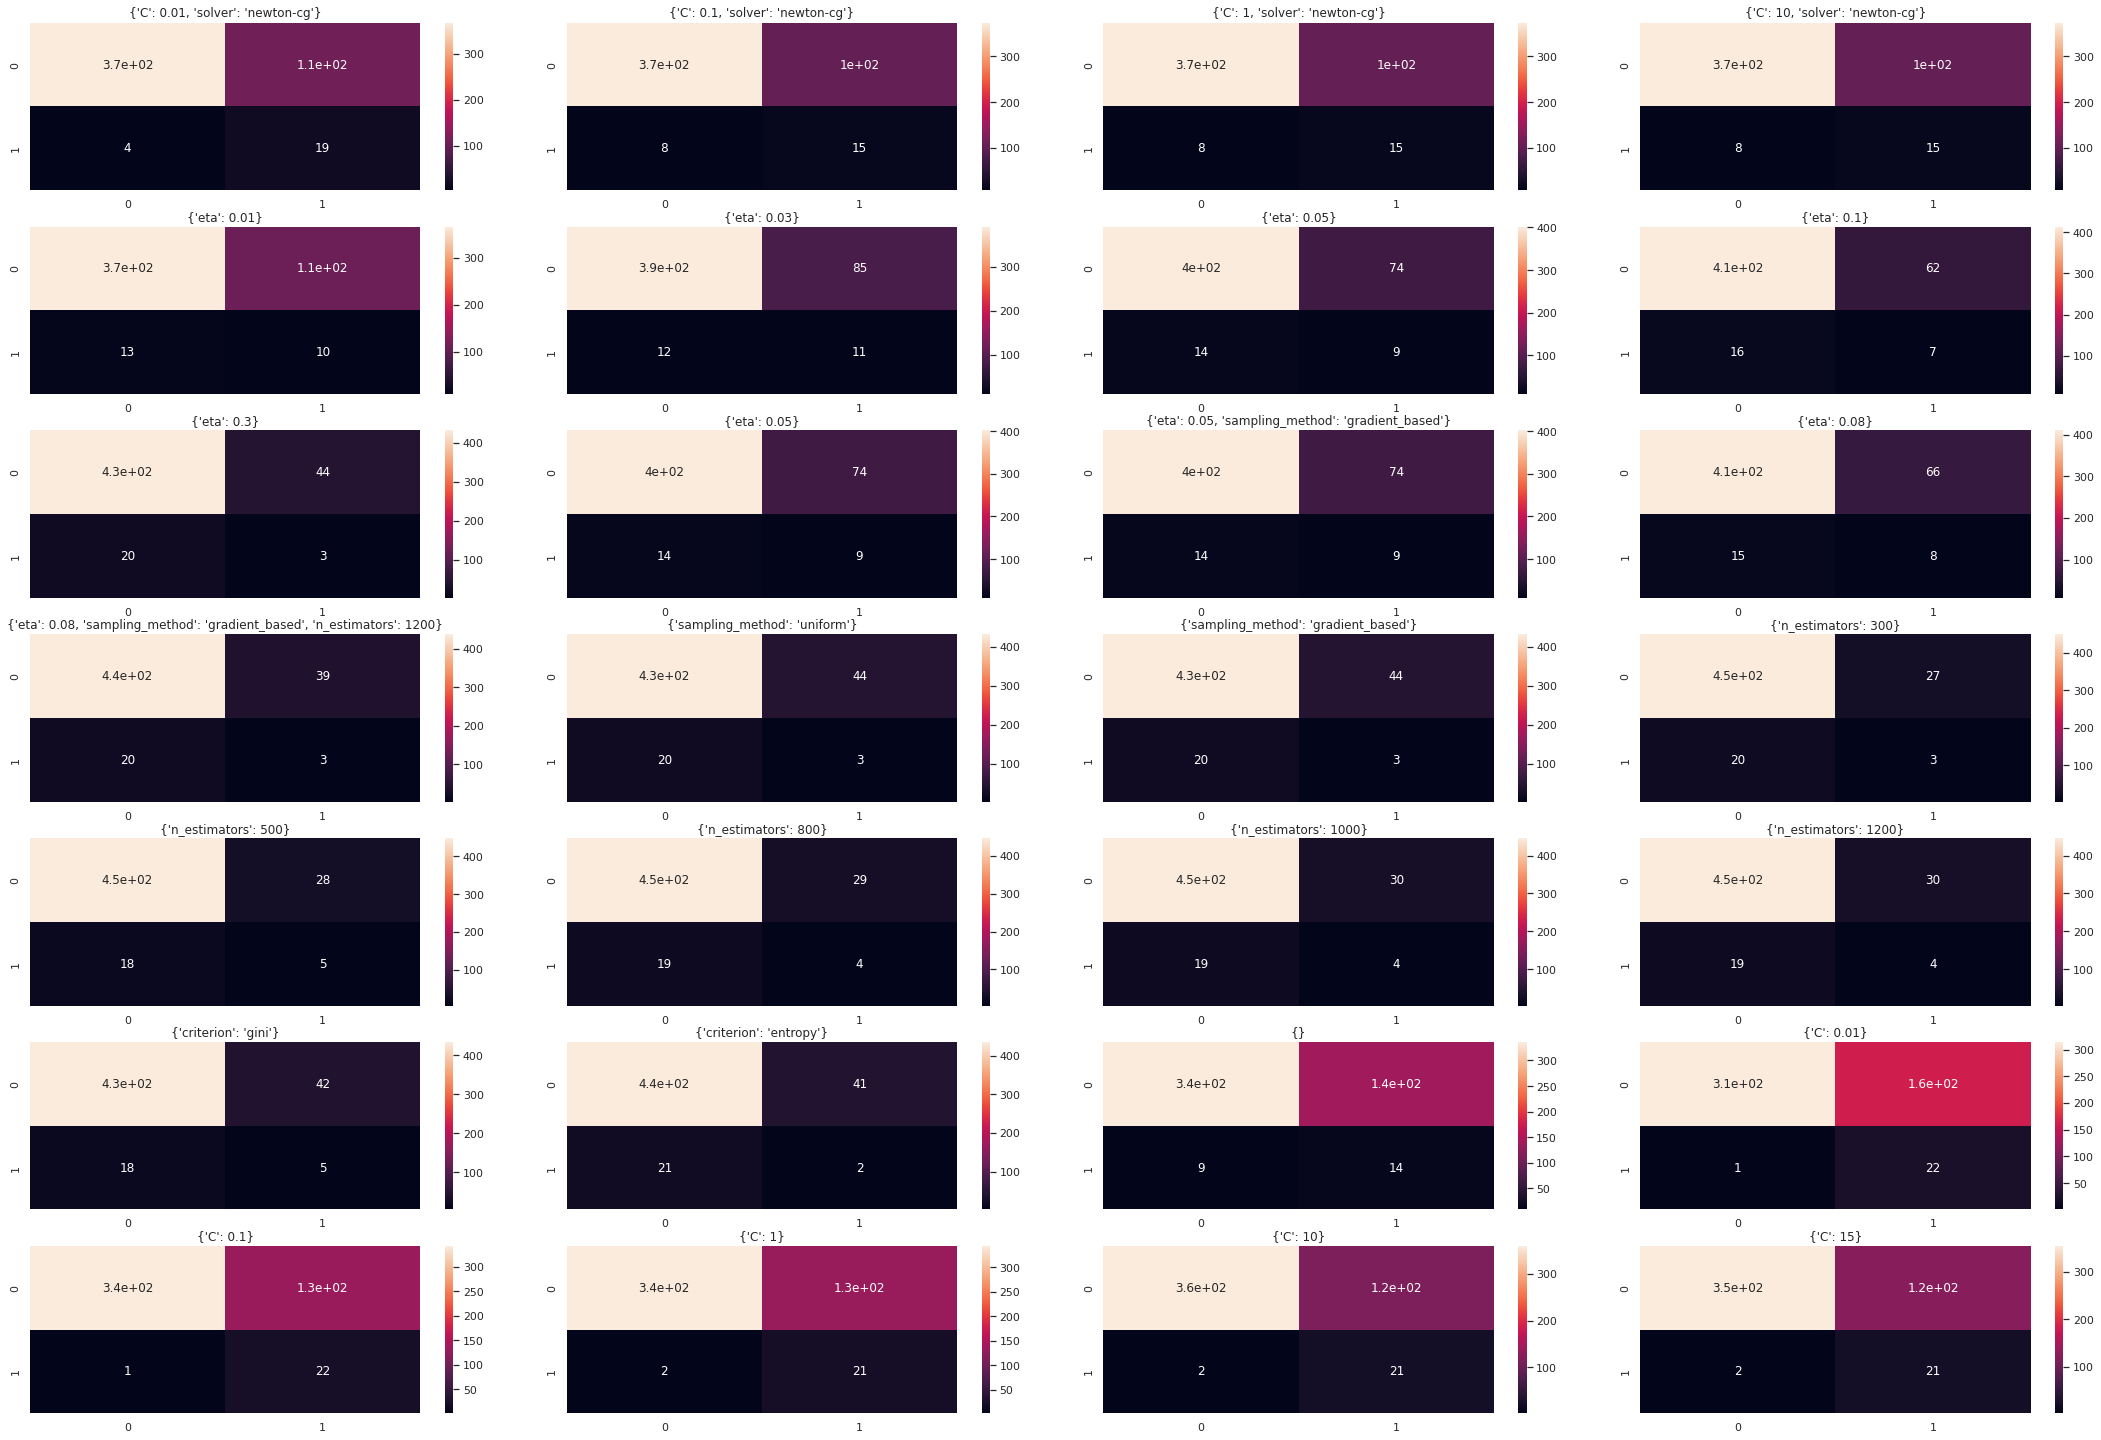

In [72]:
fig, axes = plt.subplots(7, 4)
k = 0
plt.tight_layout()
for i in range(7):
    for j in range(4):
        axes[i,j].set_title(conf_mats_2[k][3])
        sns.heatmap(conf_mats_2[k][2], annot=True, ax=axes[i,j])
        k = k+1

As we can see there is a small improvement in classifying true positives with our best performing model as per score i.e. XGBoost classifier with n-esitmators:500. 

Now some insights (model):
* XGBoost with lower learning rate had crazy false positives. The performace improved as we increased the learning rate.
* XGBoost with n-estimator variants performed quite well. It might be a great idea to look into these variants with different learning rates.
* SVC had one of the worst performances. However, there is an interesting tidbit, SVC gave wild false positives but it gave quite low false negative. When considering medical situations, I think(as I am not a medical professional) that false negatives are far more lethal than false positives. Though it cannot be overlooked that it gave insane amounts of false positives. 
* Logistic regression suffers from the same problem as SVC. Too many false positives but quite less false negatives.

Insights regarding study:
* It is apparent that there is a positive relationship between age and stroke.
* Diabetic patients are more at risk of stroke.
* It can be noted that people are overweight and obese are at a higher risk of stroke.
* There is a positive relationship between hypertension and stroke.
* People who are self-employed have a higher chance of having a brain-stroke rather than people who have government or private jobs.